<a href="https://colab.research.google.com/github/DavidScanu/oc-ai-engineer-p08-images-systeme-voiture-autonome/blob/main/notebooks/p08_david_scanu_notebook_MobileNetV2_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet 8 : Traitement d'images pour le système embarqué d'une voiture autonome

> 🎓 OpenClassrooms • Parcours [AI Engineer](https://openclassrooms.com/fr/paths/795-ai-engineer) | 👋 *Étudiant* : [David Scanu](https://www.linkedin.com/in/davidscanu14/)

## 🌐 Contexte
Ce projet s'inscrit dans le développement d'un **système embarqué de vision par ordinateur** pour véhicules autonomes chez **Future Vision Transport**. L'entreprise conçoit des systèmes permettant aux véhicules autonomes de percevoir leur environnement grâce à l'analyse d'images en temps réel.

## ⚡ Mission
En tant qu'ingénieur IA dans l'équipe R&D, notre mission est de **développer le module de segmentation d'images** (composant 3) qui s'intègre entre le module de traitement d'images (2) et le système de décision (4). Ce module doit être capable d'**identifier et de segmenter précisément 8 catégories principales d'objets** dans des images de caméras embarquées.

## 🎯 Objectifs pédagogiques
- Développer un modèle de segmentation d'images performant avec Keras/TensorFlow
- Concevoir et déployer une API REST avec FastAPI
- Créer une application web de démonstration avec Next.js
- Mettre en place un pipeline d'entraînement et de déploiement complet
- Évaluer et améliorer les performances du modèle
- Documenter le processus et les résultats de façon claire et professionnelle

## 🗓️ Plan de travail

1. **Exploration et préparation des données**
   - Analyse du jeu de données fourni par Franck (images et masques segmentés)
   - Prétraitement et augmentation des données
   - Création d'un générateur de données optimisé

2. **Développement du modèle de segmentation**
   - Étude des architectures de l'état de l'art (U-Net, DeepLabV3+, etc.)
   - Implémentation avec Keras
   - Entraînement et optimisation du modèle

3. **Déploiement du modèle**
   - Développement d'une API FastAPI
   - Création d'une application frontend Next.js
   - Déploiement sur Heroku

4. **Évaluation et documentation**
   - Tests et validation des performances
   - Rédaction du rapport technique
   - Préparation de la présentation

## 💾 Dépôt GitHub

> https://github.com/DavidScanu/oc-ai-engineer-p08-images-systeme-voiture-autonome

## 👋 À propos

Projet développé par [David Scanu](https://www.linkedin.com/in/davidscanu14/) dans le cadre du parcours [AI Engineer](https://openclassrooms.com/fr/paths/795-ai-engineer) d'OpenClassrooms : **Projet 8 - Traitez les images pour le système embarqué d'une voiture autonome**.


## GPU et mémoire RAM

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jun 30 12:12:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

## 🔗 Connexion à Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 🚗 Jeu de données

Nous utilisons le jeu de données [Cityscapes](https://www.cityscapes-dataset.com/dataset-overview/) qui se concentre sur la compréhension sémantique des scènes urbaines.

Pour notre modèle de segmentation d'images, nous exploitons les **5 000 images annotées avec des annotations fines** (fine annotations).

Ce dataset présente plusieurs caractéristiques essentielles pour notre cas d'usage :
- Des annotations polygonales permettant une segmentation sémantique dense
- Une couverture de 30 classes dont nous retiendrons uniquement les **8 catégories principales** (flat, human, vehicle, construction, object, nature, sky, void)
- Une diversité importante avec des données provenant de **50 villes différentes**, capturées sur plusieurs mois (printemps, été, automne)
- Des conditions variées mais contrôlées (jour, conditions météorologiques bonnes à moyennes)
- Des **scènes sélectionnées manuellement pour leur complexité** (nombreux objets dynamiques, variations dans l'agencement des scènes et l'arrière-plan)

**Documentation**

- https://www.cityscapes-dataset.com/dataset-overview/
- https://github.com/mcordts/cityscapesScripts



Nous utilisons le jeu de données **Cityscapes** qui contient **5 000 images avec des annotations fines** :
- Entraînement : 2 975
- Validation : 500
- Test : 1 525

Le format Cityscapes fournit plusieurs fichiers d'annotation pour chaque image originale. Cette structure facilite différentes approches de traitement et d'apprentissage. Pour chaque image d'origine, nous disposons de :
- Des fichiers `*_gtFine_instanceIds.png` qui encodent à la fois la classe et l'identifiant d'instance de chaque pixel
- Des fichiers `*_gtFine_labelIds.png` qui contiennent uniquement les identifiants de classe pour la segmentation sémantique
- Des fichiers `*_gtFine_color.png` qui offrent une représentation visuelle colorée des segmentations
- Des fichiers `*_gtFine_polygons.json` qui stockent les annotations sous forme vectorielle (polygones)

Cette richesse d'annotations nous permettra de développer un modèle robuste pour notre système de vision par ordinateur embarqué chez Future Vision Transport.

## Configuration de l'environnement et des dépendances

In [ ]:
!pip install mlflow boto3 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import os
import sys
import random
import json
import shutil
import zipfile
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import requests

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import data as tf_data
import keras
import keras_hub

# MLflow
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature
from mlflow import MlflowClient
from mlflow.models.signature import ModelSignature
from mlflow.types import Schema, ColSpec, TensorSpec
from google.colab import userdata

In [ ]:
# Vérification de la configuration
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"CUDA disponible: {tf.config.list_physical_devices('GPU')}")

# Définition des chemins des données
g_drive_dir = "/content/drive/MyDrive/openclassrooms/projets/p08-images-systeme-voiture-autonome/notebooks"
g_drive_dir_content = os.path.join(g_drive_dir, "content")
data_dir = os.path.join(g_drive_dir_content, "data")
cityscapes_dir = os.path.join(data_dir, "cityscapes")

# Création des dossiers s'il n'existent pas déjà
os.makedirs(cityscapes_dir, exist_ok=True)
# os.makedirs(os.path.join(g_drive_dir_content, 'models'), exist_ok=True)
# os.makedirs(os.path.join(g_drive_dir_content, 'models', 'checkpoints'), exist_ok=True)
# os.makedirs(os.path.join(g_drive_dir_content, 'logs'), exist_ok=True)


# Configuration des graines aléatoires pour la reproductibilité
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Configuration de MLflow
mlflow_tracking_uri = userdata.get("MLFLOW_TRACKING_URI")
aws_access_key_id = userdata.get("AWS_ACCESS_KEY_ID")
aws_secret_access_key = userdata.get("AWS_SECRET_ACCESS_KEY")

# Configuration explicite de MLflow
mlflow.set_tracking_uri(mlflow_tracking_uri)
print(f"MLflow Tracking URI: {mlflow_tracking_uri}")

# Configuration explicite des identifiants AWS
os.environ["AWS_ACCESS_KEY_ID"] = aws_access_key_id
os.environ["AWS_SECRET_ACCESS_KEY"] = aws_secret_access_key
print("Identifiants AWS configurés")

# Créer l'expérience MLflow
mlflow.set_experiment("OC Projet 8")

# Paramètres globaux
device = 'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'
print(f"Appareil utilisé: {device}")

In [ ]:
# Define target image size - use 224x224 which is more compatible with MobileNetV2
img_size = (224, 224)
batch_size = 8

## Téléchargement et préparation des données Cityscapes

In [ ]:
def download_and_extract_cityscapes():
    """Télécharge et extrait les données Cityscapes si elles n'existent pas déjà"""

    # Création des répertoires nécessaires s'ils n'existent pas
    os.makedirs(data_dir, exist_ok=True)

    # Liens vers les fichiers zip Cityscapes
    gtFine_url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_gtFine_trainvaltest.zip"
    leftImg_url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_leftImg8bit_trainvaltest.zip"

    # Chemins locaux pour les fichiers zip
    gtFine_zip = os.path.join(data_dir, "P8_Cityscapes_gtFine_trainvaltest.zip")
    leftImg_zip = os.path.join(data_dir, "P8_Cityscapes_leftImg8bit_trainvaltest.zip")

    # Fonction pour télécharger un fichier avec barre de progression
    def download_file(url, filename):
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Vérification des erreurs HTTP

        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 KB
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)

        with open(filename, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)

        progress_bar.close()

        if total_size != 0 and progress_bar.n != total_size:
            print("ERREUR: le téléchargement n'est pas complet")
            return False

        return True

    # Vérification si les fichiers d'annotations et d'images existent déjà
    if not os.path.exists(os.path.join(cityscapes_dir, "gtFine")) or not os.path.exists(os.path.join(cityscapes_dir, "leftImg8bit")):
        # Téléchargement des fichiers zip si nécessaire
        if not os.path.exists(gtFine_zip):
            print("Téléchargement des annotations (gtFine)...")
            success = download_file(gtFine_url, gtFine_zip)
            if not success:
                print("Erreur lors du téléchargement des annotations.")
                return False
            print("Téléchargement des annotations terminé.")

        if not os.path.exists(leftImg_zip):
            print("Téléchargement des images (leftImg8bit)...")
            success = download_file(leftImg_url, leftImg_zip)
            if not success:
                print("Erreur lors du téléchargement des images.")
                return False
            print("Téléchargement des images terminé.")

        # Vérification si les fichiers ont bien été téléchargés
        if not os.path.exists(gtFine_zip) or not os.path.exists(leftImg_zip):
            print("Erreur: Les fichiers zip n'ont pas pu être téléchargés.")
            print(f"Vérifiez les chemins: {gtFine_zip} et {leftImg_zip}")
            return False

        # Extraction des fichiers zip
        print("Extraction des annotations...")
        try:
            with zipfile.ZipFile(gtFine_zip, 'r') as zip_ref:
                # Extraction avec barre de progression
                for member in tqdm(zip_ref.infolist(), desc="Extraction gtFine"):
                    zip_ref.extract(member, cityscapes_dir)
            print("Extraction des annotations terminée.")
        except zipfile.BadZipFile:
            print(f"Erreur: {gtFine_zip} n'est pas un fichier ZIP valide.")
            return False

        print("Extraction des images...")
        try:
            with zipfile.ZipFile(leftImg_zip, 'r') as zip_ref:
                # Extraction avec barre de progression
                for member in tqdm(zip_ref.infolist(), desc="Extraction leftImg8bit"):
                    zip_ref.extract(member, cityscapes_dir)
            print("Extraction des images terminée.")
        except zipfile.BadZipFile:
            print(f"Erreur: {leftImg_zip} n'est pas un fichier ZIP valide.")
            return False

        print("Préparation des données Cityscapes terminée.")
    else:
        print("Les données Cityscapes sont déjà téléchargées et extraites.")

    return True

# Télécharger et extraire les données Cityscapes
download_and_extract_cityscapes()

Les données Cityscapes sont déjà téléchargées et extraites.


True

## Définition des classes et mapping pour la segmentation

In [ ]:
# Définition des classes Cityscapes par groupe selon la capture d'écran
class_groups = {
    'flat': ['road', 'sidewalk', 'parking', 'rail track'],
    'human': ['person', 'rider'],
    'vehicle': ['car', 'truck', 'bus', 'on rails', 'motorcycle', 'bicycle', 'caravan', 'trailer'],
    'construction': ['building', 'wall', 'fence', 'guard rail', 'bridge', 'tunnel'],
    'object': ['pole', 'pole group', 'traffic sign', 'traffic light'],
    'nature': ['vegetation', 'terrain'],
    'sky': ['sky'],
    'void': ['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground']
}

# Définition du mapping entre les ID originaux de Cityscapes et nos groupes
cityscapes_mapping = {
    # void
    0: 7,  # 'unlabeled' -> 'void'
    1: 7,  # 'ego vehicle' -> 'void'
    2: 7,  # 'rectification border' -> 'void'
    3: 7,  # 'out of roi' -> 'void'
    4: 7,  # 'static' -> 'void'
    5: 7,  # 'dynamic' -> 'void'
    6: 7,  # 'ground' -> 'void'

    # flat
    7: 0,  # 'road' -> 'flat'
    8: 0,  # 'sidewalk' -> 'flat'
    9: 0,  # 'parking' -> 'flat'
    10: 0, # 'rail track' -> 'flat'

    # construction
    11: 3, # 'building' -> 'construction'
    12: 3, # 'wall' -> 'construction'
    13: 3, # 'fence' -> 'construction'
    14: 3, # 'guard rail' -> 'construction'
    15: 3, # 'bridge' -> 'construction'
    16: 3, # 'tunnel' -> 'construction'

    # object
    17: 4, # 'pole' -> 'object'
    18: 4, # 'pole group' -> 'object'
    19: 4, # 'traffic light' -> 'object'
    20: 4, # 'traffic sign' -> 'object'

    # nature
    21: 5, # 'vegetation' -> 'nature'
    22: 5, # 'terrain' -> 'nature'

    # sky
    23: 6, # 'sky' -> 'sky'

    # human
    24: 1, # 'person' -> 'human'
    25: 1, # 'rider' -> 'human'

    # vehicle
    26: 2, # 'car' -> 'vehicle'
    27: 2, # 'truck' -> 'vehicle'
    28: 2, # 'bus' -> 'vehicle'
    29: 2, # 'caravan' -> 'vehicle'
    30: 2, # 'trailer' -> 'vehicle'
    31: 2, # 'train' -> 'vehicle'
    32: 2, # 'motorcycle' -> 'vehicle'
    33: 2, # 'bicycle' -> 'vehicle'
}

# On crée un tableau pour faciliter la conversion des ID
id_to_group = np.zeros(256, dtype=np.uint8)
for id, group_id in cityscapes_mapping.items():
    id_to_group[id] = group_id

# Définition des couleurs pour la visualisation des groupes
group_colors = [
    [128, 64, 128],  # flat - bleu-gris
    [220, 20, 60],   # human - rouge
    [0, 0, 142],     # vehicle - bleu foncé
    [70, 70, 70],    # construction - gris
    [220, 220, 0],   # object - jaune
    [107, 142, 35],  # nature - vert
    [70, 130, 180],  # sky - bleu ciel
    [0, 0, 0]        # void - noir
]

# Noms des groupes
group_names = ['flat', 'human', 'vehicle', 'construction', 'object', 'nature', 'sky', 'void']
num_classes = len(group_names)

## Préparation des données

In [ ]:
def prepare_dataset_with_split(dataset_path, split='train', batch_size=8, img_size=(224, 224), validation_split=0.2):
    """
    Prépare un dataset avec division automatique train/validation

    Args:
        dataset_path: Chemin vers les données Cityscapes
        split: 'train', 'val', ou 'test'
        batch_size: Taille du batch
        img_size: Taille des images de sortie
        validation_split: Pourcentage à utiliser pour la validation (seulement pour split='train')

    Returns:
        Si split='train': retourne (train_dataset, val_dataset)
        Sinon: retourne le dataset demandé
    """
    images_dir = os.path.join(dataset_path, 'leftImg8bit', split)
    masks_dir = os.path.join(dataset_path, 'gtFine', split)

    # Lists to store image and mask paths
    image_paths = []
    mask_paths = []

    # Go through all city directories
    for city in os.listdir(images_dir):
        city_img_dir = os.path.join(images_dir, city)
        city_mask_dir = os.path.join(masks_dir, city)

        # Find all matching image and mask files
        for file_name in os.listdir(city_img_dir):
            if file_name.endswith('_leftImg8bit.png'):
                img_path = os.path.join(city_img_dir, file_name)
                mask_name = file_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                mask_path = os.path.join(city_mask_dir, mask_name)

                if os.path.exists(mask_path):
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)

    print(f"{split} dataset: {len(image_paths)} images found")

    # Si c'est le dataset d'entraînement, le diviser en train/val
    if split == 'train' and validation_split > 0:
        # Mélanger les données de façon reproductible
        import random
        combined = list(zip(image_paths, mask_paths))
        random.seed(42)  # Pour la reproductibilité
        random.shuffle(combined)
        image_paths, mask_paths = zip(*combined)

        # Calculer les indices de division
        total_samples = len(image_paths)
        val_samples = int(total_samples * validation_split)
        train_samples = total_samples - val_samples

        # Diviser les données
        train_img_paths = list(image_paths[:train_samples])
        train_mask_paths = list(mask_paths[:train_samples])
        val_img_paths = list(image_paths[train_samples:])
        val_mask_paths = list(mask_paths[train_samples:])

        print(f"  └─ Train: {len(train_img_paths)} images")
        print(f"  └─ Validation: {len(val_img_paths)} images")

        # Créer les datasets
        train_dataset = create_dataset_from_paths(train_img_paths, train_mask_paths, batch_size, img_size, augment=True)
        val_dataset = create_dataset_from_paths(val_img_paths, val_mask_paths, batch_size, img_size, augment=False)

        return train_dataset, val_dataset

    else:
        # Pour 'val' (qui devient notre test) ou autres
        dataset = create_dataset_from_paths(image_paths, mask_paths, batch_size, img_size, augment=False)
        return dataset

def create_dataset_from_paths(image_paths, mask_paths, batch_size, img_size, augment=False):
    """Crée un dataset TensorFlow à partir de listes de chemins"""

    # Create a dataset from the file paths
    path_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    # Function to load and preprocess an image and its mask
    def load_and_preprocess(img_path, mask_path):
        # Load and decode the image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, img_size, method='bilinear')
        # Normalize image to [0,1] range
        img = tf.cast(img, tf.float32) / 255.0

        # Load and decode the mask
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, img_size, method='nearest')
        mask = tf.cast(mask, tf.int32)

        # Map original IDs to our group IDs
        flat_mask = tf.reshape(mask, [-1])
        mapped_mask = tf.gather(tf.constant(id_to_group, dtype=tf.int32), flat_mask)
        mask = tf.reshape(mapped_mask, tf.shape(mask))

        # Ensure mask is 2D by removing the channel dimension
        mask = tf.squeeze(mask, axis=-1)

        return img, mask

    # Apply preprocessing
    dataset = path_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # Add augmentation if requested
    if augment:
        def augment_data(image, mask):
            # Add a dimension to mask for flip operations
            mask = tf.expand_dims(mask, axis=-1)

            # Random horizontal flip
            if tf.random.uniform(()) > 0.5:
                image = tf.image.flip_left_right(image)
                mask = tf.image.flip_left_right(mask)

            # Random brightness (only for image)
            image = tf.image.random_brightness(image, 0.1)
            image = tf.clip_by_value(image, 0, 1)

            # Remove the added dimension
            mask = tf.squeeze(mask, axis=-1)

            return image, mask

        dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# WORKS

# def prepare_dataset(dataset_path, split='train', batch_size=8, img_size=(224, 224)):
#     """
#     Prepare a dataset from raw files with consistent sizes
#     """
#     images_dir = os.path.join(dataset_path, 'leftImg8bit', split)
#     masks_dir = os.path.join(dataset_path, 'gtFine', split)

#     # Lists to store image and mask paths
#     image_paths = []
#     mask_paths = []

#     # Go through all city directories
#     for city in os.listdir(images_dir):
#         city_img_dir = os.path.join(images_dir, city)
#         city_mask_dir = os.path.join(masks_dir, city)

#         # Find all matching image and mask files
#         for file_name in os.listdir(city_img_dir):
#             if file_name.endswith('_leftImg8bit.png'):
#                 img_path = os.path.join(city_img_dir, file_name)
#                 mask_name = file_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
#                 mask_path = os.path.join(city_mask_dir, mask_name)

#                 if os.path.exists(mask_path):
#                     image_paths.append(img_path)
#                     mask_paths.append(mask_path)

#     print(f"{split} dataset: {len(image_paths)} images found")

#     # Create a dataset from the file paths
#     path_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

#     # Function to load and preprocess an image and its mask
#     def load_and_preprocess(img_path, mask_path):
#         # Load and decode the image
#         img = tf.io.read_file(img_path)
#         img = tf.image.decode_png(img, channels=3)
#         img = tf.image.resize(img, img_size, method='bilinear')
#         # Normalize image to [0,1] range - mobile net preprocessing will be applied in model
#         img = tf.cast(img, tf.float32) / 255.0

#         # Load and decode the maska
#         mask = tf.io.read_file(mask_path)
#         mask = tf.image.decode_png(mask, channels=1)
#         mask = tf.image.resize(mask, img_size, method='nearest')
#         mask = tf.cast(mask, tf.int32)

#         # Map original IDs to our group IDs
#         flat_mask = tf.reshape(mask, [-1])
#         mapped_mask = tf.gather(tf.constant(id_to_group, dtype=tf.int32), flat_mask)
#         mask = tf.reshape(mapped_mask, tf.shape(mask))

#         # Ensure mask is 2D by removing the channel dimension
#         mask = tf.squeeze(mask, axis=-1)

#         return img, mask

#     # Apply preprocessing
#     dataset = path_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

#     # Add simple augmentation for training
#     if split == 'train':
#         def augment(image, mask):
#             # Add a dimension to mask for flip operations
#             mask = tf.expand_dims(mask, axis=-1)

#             # Random horizontal flip
#             if tf.random.uniform(()) > 0.5:
#                 image = tf.image.flip_left_right(image)
#                 mask = tf.image.flip_left_right(mask)

#             # Random brightness (only for image)
#             image = tf.image.random_brightness(image, 0.1)
#             image = tf.clip_by_value(image, 0, 1)

#             # Remove the added dimension
#             mask = tf.squeeze(mask, axis=-1)

#             return image, mask

#         dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

#     # Batch and prefetch
#     dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

#     return dataset

In [ ]:
# Prepare datasets directly from files with consistent size
# train_dataset = prepare_dataset(cityscapes_dir, split='train', batch_size=batch_size, img_size=img_size)
# val_dataset = prepare_dataset(cityscapes_dir, split='val', batch_size=batch_size, img_size=img_size)
# test_dataset = prepare_dataset(cityscapes_dir, split='test', batch_size=batch_size, img_size=img_size)

- `train_dataset` : pour l'entraînement
- `val_dataset` : pour la validation pendant l'entraînement

In [ ]:
# Préparer les datasets avec la nouvelle approche
print("=== PRÉPARATION DES DATASETS ===")

# 1. Diviser le dataset 'train' original en train/val (80%/20%)
train_dataset, val_dataset = prepare_dataset_with_split(
    cityscapes_dir,
    split='train',
    batch_size=batch_size,
    img_size=img_size,
    validation_split=0.2
)

# 2. Utiliser le dataset 'val' original comme dataset de test final
test_dataset = prepare_dataset_with_split(
    cityscapes_dir,
    split='val',  # L'ancien 'val' devient notre 'test'
    batch_size=batch_size,
    img_size=img_size
)

print(f"\n✅ Datasets créés:")
print(f"   📚 Train: ~{2975 * 0.8:.0f} images (avec augmentation)")
print(f"   📊 Validation: ~{2975 * 0.2:.0f} images")
print(f"   🧪 Test: ~500 images (ancien dataset val)")

=== PRÉPARATION DES DATASETS ===
train dataset: 2975 images found
  └─ Train: 2380 images
  └─ Validation: 595 images
val dataset: 500 images found

✅ Datasets créés:
   📚 Train: ~2380 images (avec augmentation)
   📊 Validation: ~595 images
   🧪 Test: ~500 images (ancien dataset val)


In [ ]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224), dtype=tf.int32, name=None))>

Visualisation d'un échantillon du dataset d'entraînement:


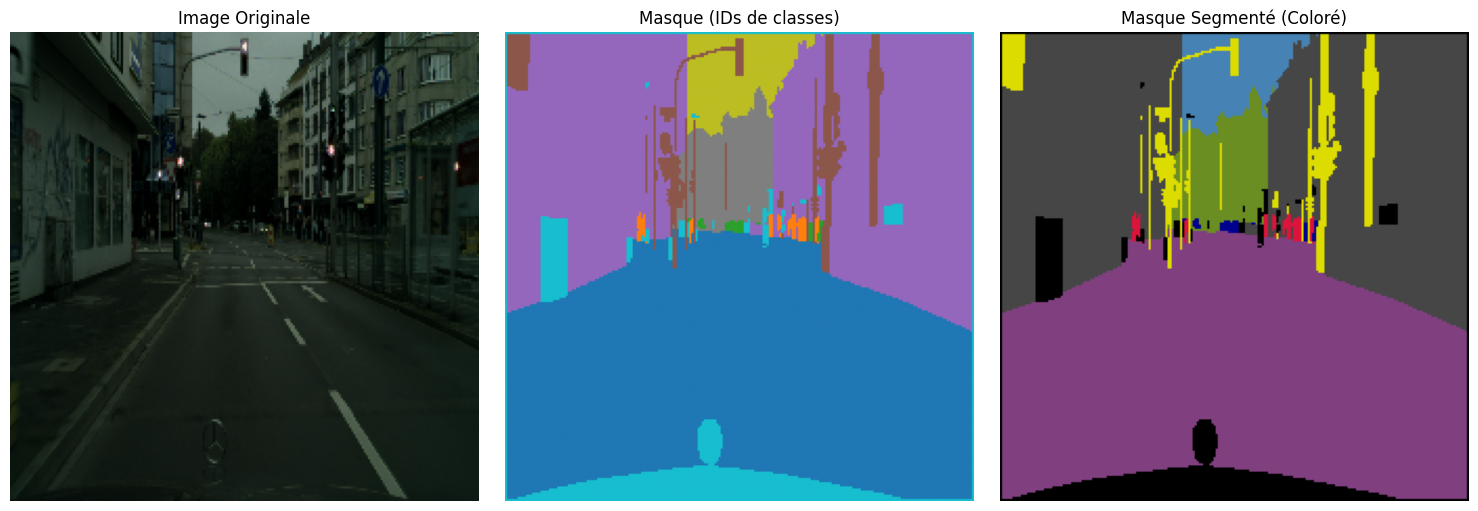


Classes présentes dans cette image:
  flat: 22045 pixels (43.9%)
  human: 204 pixels (0.4%)
  vehicle: 102 pixels (0.2%)
  construction: 17986 pixels (35.8%)
  object: 2304 pixels (4.6%)
  nature: 2001 pixels (4.0%)
  sky: 1821 pixels (3.6%)
  void: 3713 pixels (7.4%)


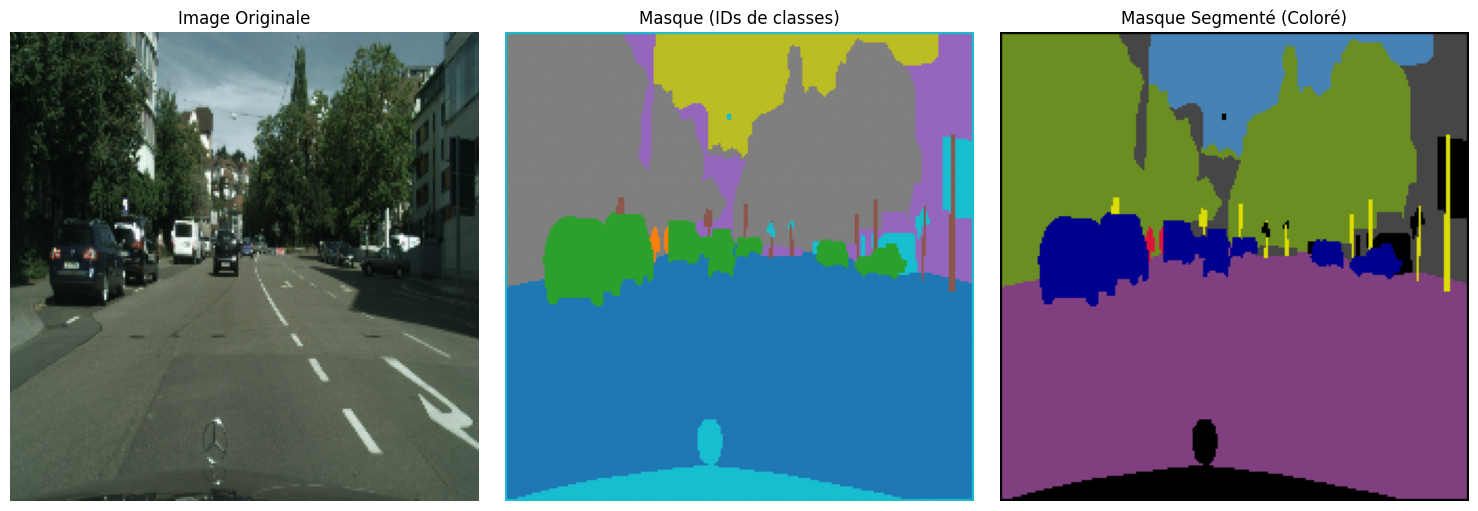


Classes présentes dans cette image:
  flat: 21887 pixels (43.6%)
  human: 68 pixels (0.1%)
  vehicle: 2923 pixels (5.8%)
  construction: 3571 pixels (7.1%)
  object: 444 pixels (0.9%)
  nature: 14143 pixels (28.2%)
  sky: 3522 pixels (7.0%)
  void: 3618 pixels (7.2%)

Visualisation d'un échantillon du dataset de validation:


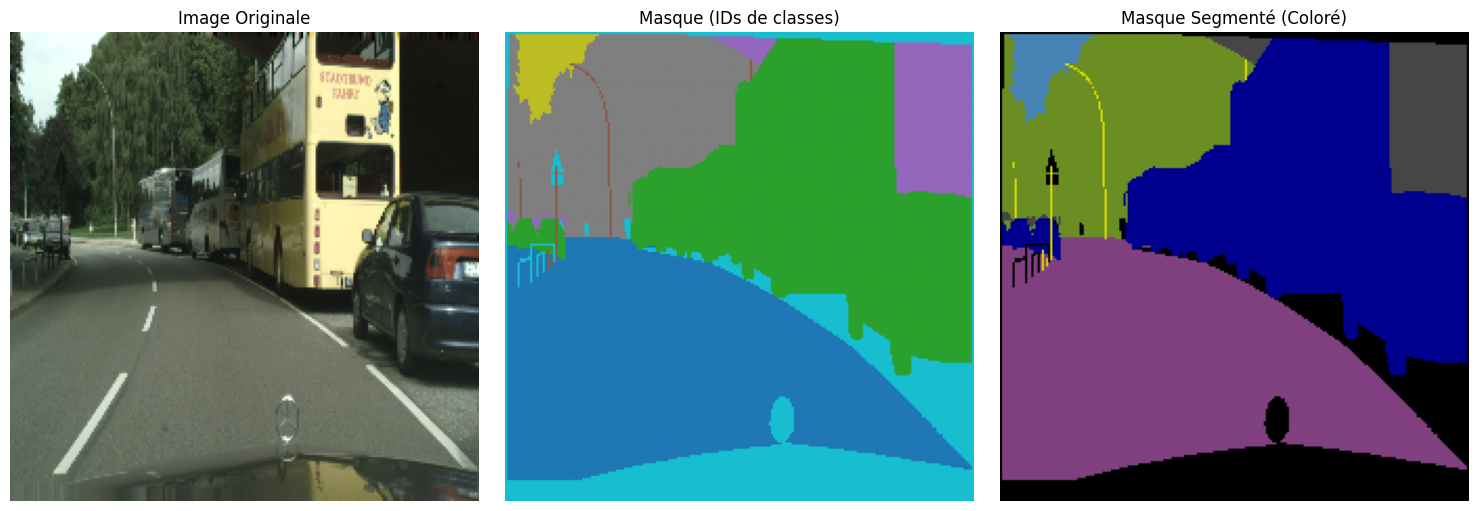


Classes présentes dans cette image:
  flat: 16225 pixels (32.3%)
  vehicle: 14738 pixels (29.4%)
  construction: 2898 pixels (5.8%)
  object: 177 pixels (0.4%)
  nature: 7493 pixels (14.9%)
  sky: 892 pixels (1.8%)
  void: 7753 pixels (15.5%)


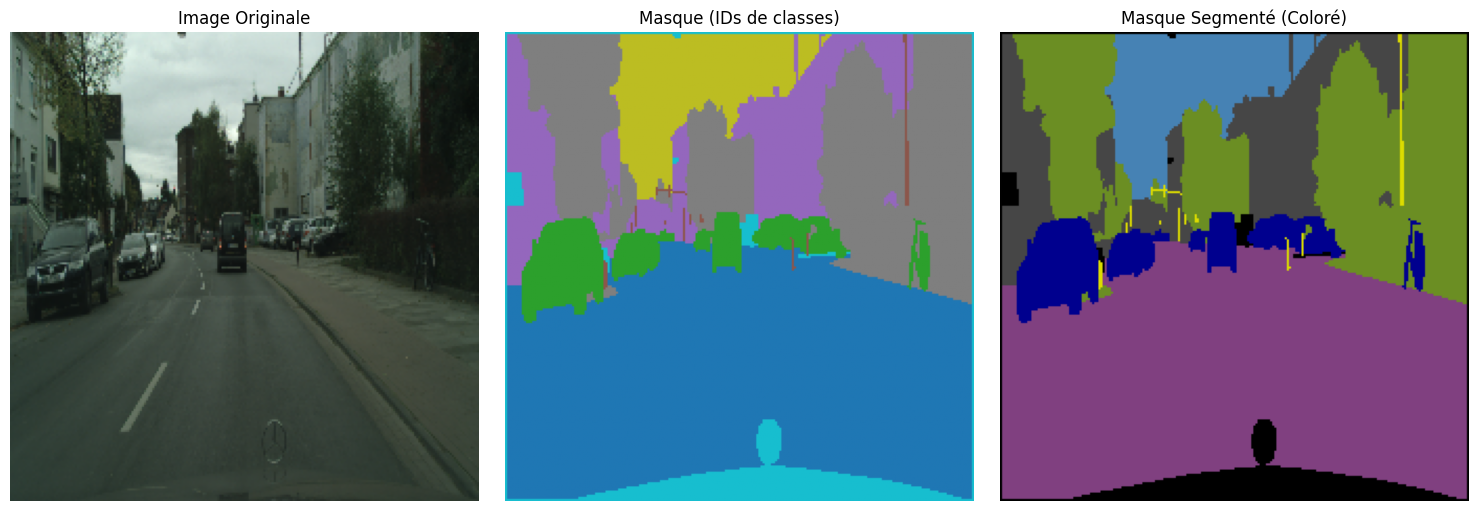


Classes présentes dans cette image:
  flat: 21656 pixels (43.2%)
  vehicle: 3166 pixels (6.3%)
  construction: 5930 pixels (11.8%)
  object: 238 pixels (0.5%)
  nature: 11999 pixels (23.9%)
  sky: 4034 pixels (8.0%)
  void: 3153 pixels (6.3%)

Visualisation d'un échantillon du dataset de test:


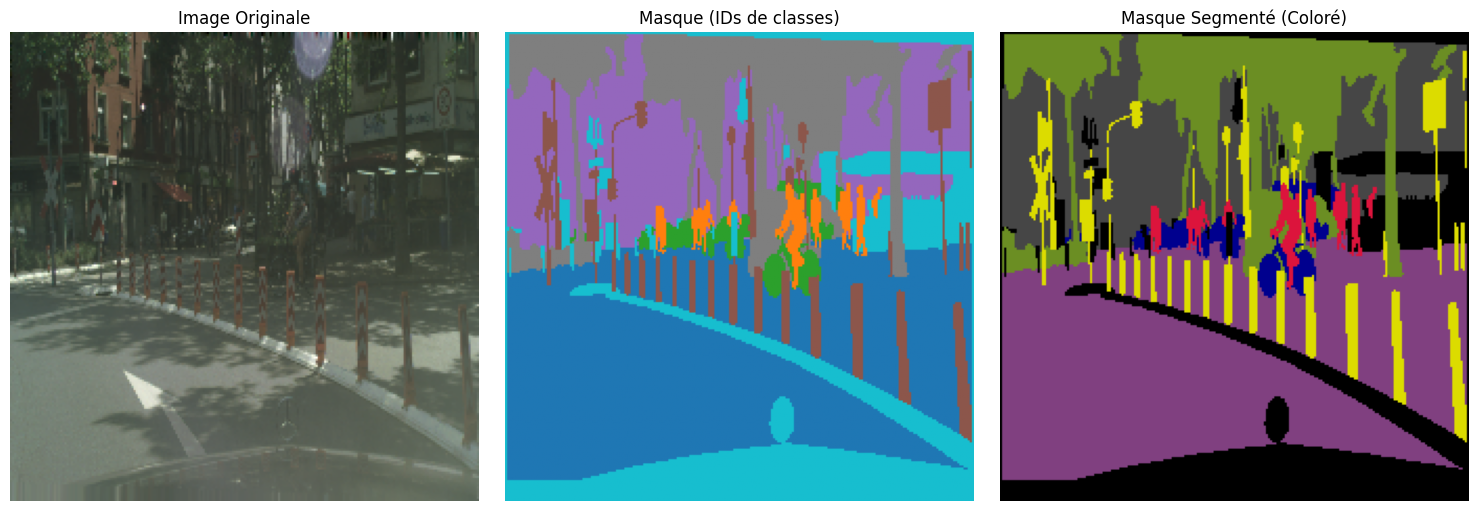


Classes présentes dans cette image:
  flat: 17818 pixels (35.5%)
  human: 964 pixels (1.9%)
  vehicle: 1017 pixels (2.0%)
  construction: 8910 pixels (17.8%)
  object: 3622 pixels (7.2%)
  nature: 8242 pixels (16.4%)
  void: 9603 pixels (19.1%)


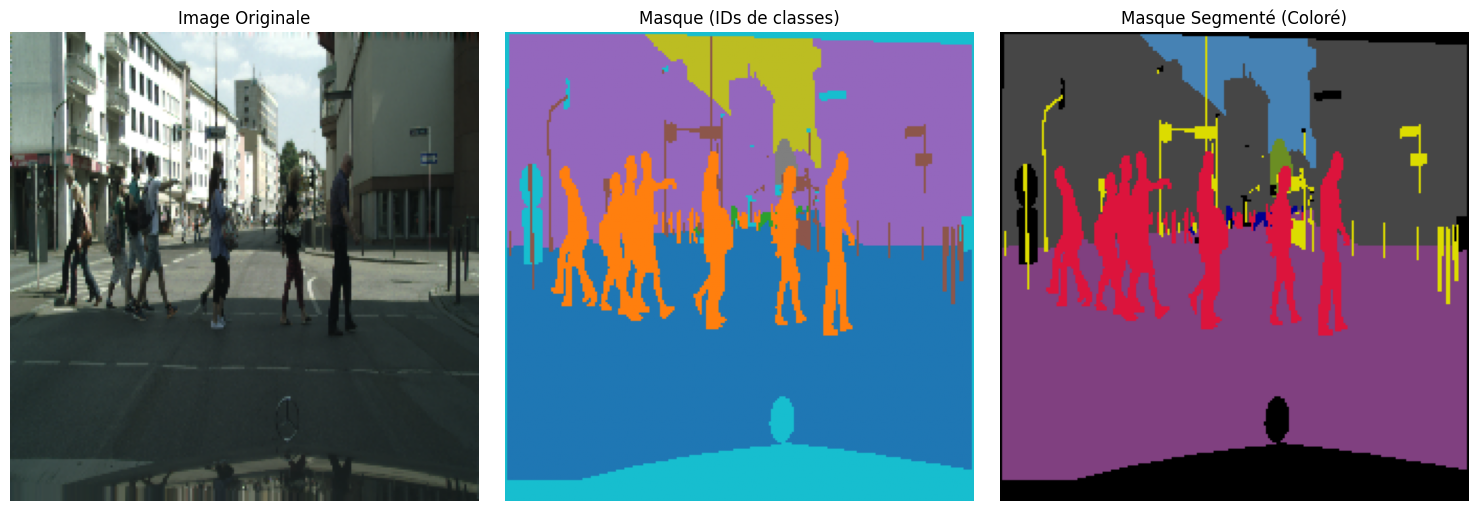


Classes présentes dans cette image:
  flat: 20731 pixels (41.3%)
  human: 4416 pixels (8.8%)
  vehicle: 78 pixels (0.2%)
  construction: 15257 pixels (30.4%)
  object: 1137 pixels (2.3%)
  nature: 153 pixels (0.3%)
  sky: 2273 pixels (4.5%)
  void: 6131 pixels (12.2%)


In [ ]:
# Visualisation d'un échantillon du dataset
def display_sample(dataset):
    """Affiche un échantillon d'images et de masques d'un dataset TensorFlow."""

    for batch in dataset.take(2):
        # Extraire les images et masques du tuple
        images, masks = batch  # Votre dataset retourne (images, masks)

        # Prendre le premier échantillon du batch
        image = images[0]
        mask = masks[0]  # Le masque est déjà 2D, pas besoin de squeeze

        plt.figure(figsize=(15, 5))

        # Afficher l'image originale
        plt.subplot(1, 3, 1)
        # L'image est normalisée [0,1], la multiplier par 255 pour l'affichage
        plt.imshow((image.numpy() * 255).astype("uint8"))
        plt.title("Image Originale")
        plt.axis("off")

        # Afficher le masque brut (en niveaux de gris)
        plt.subplot(1, 3, 2)
        plt.imshow(mask.numpy(), cmap='tab10', vmin=0, vmax=num_classes-1)
        plt.title("Masque (IDs de classes)")
        plt.axis("off")

        # Afficher le masque colorisé
        plt.subplot(1, 3, 3)
        # Convertir les ID de groupe en couleurs
        mask_array = mask.numpy()
        colored_mask = np.zeros((mask_array.shape[0], mask_array.shape[1], 3), dtype=np.uint8)

        for group_id in range(num_classes):
            colored_mask[mask_array == group_id] = group_colors[group_id]

        plt.imshow(colored_mask)
        plt.title("Masque Segmenté (Coloré)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        # Afficher les statistiques des classes présentes
        unique_classes, counts = np.unique(mask_array, return_counts=True)
        print("\nClasses présentes dans cette image:")
        for class_id, count in zip(unique_classes, counts):
            percentage = (count / mask_array.size) * 100
            print(f"  {group_names[class_id]}: {count} pixels ({percentage:.1f}%)")

# Visualiser un échantillon du dataset d'entraînement
print("Visualisation d'un échantillon du dataset d'entraînement:")
display_sample(train_dataset)

# Visualiser un échantillon du dataset de validation
print("\nVisualisation d'un échantillon du dataset de validation:")
display_sample(val_dataset)

# Optionnel: Visualiser aussi le dataset de test
print("\nVisualisation d'un échantillon du dataset de test:")
display_sample(test_dataset)

## Visualisation des données

Visualisation de 3 échantillons du jeu de données train
Sauvegardé à: /content/drive/MyDrive/openclassrooms/projets/p08-images-systeme-voiture-autonome/notebooks/content/data/samples/train_samples.png


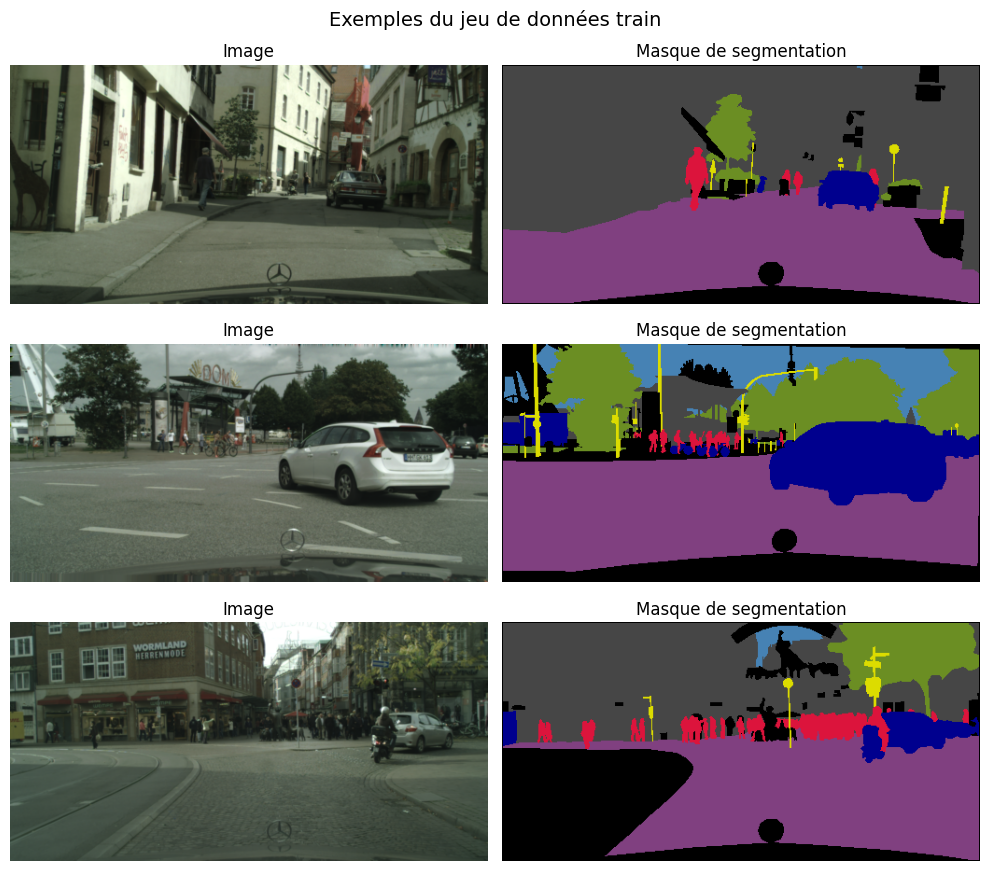


Visualisation de 3 échantillons du jeu de données val
Sauvegardé à: /content/drive/MyDrive/openclassrooms/projets/p08-images-systeme-voiture-autonome/notebooks/content/data/samples/val_samples.png


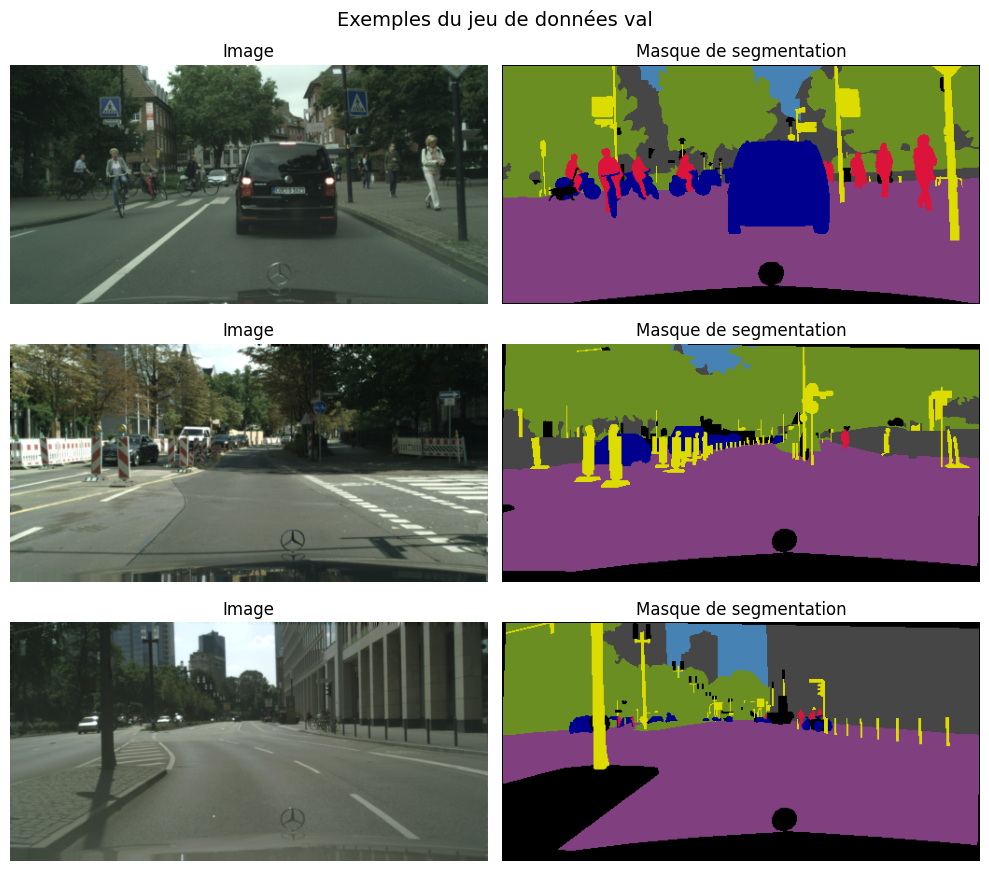


Visualisation de 3 échantillons du jeu de données test
Sauvegardé à: /content/drive/MyDrive/openclassrooms/projets/p08-images-systeme-voiture-autonome/notebooks/content/data/samples/test_samples.png


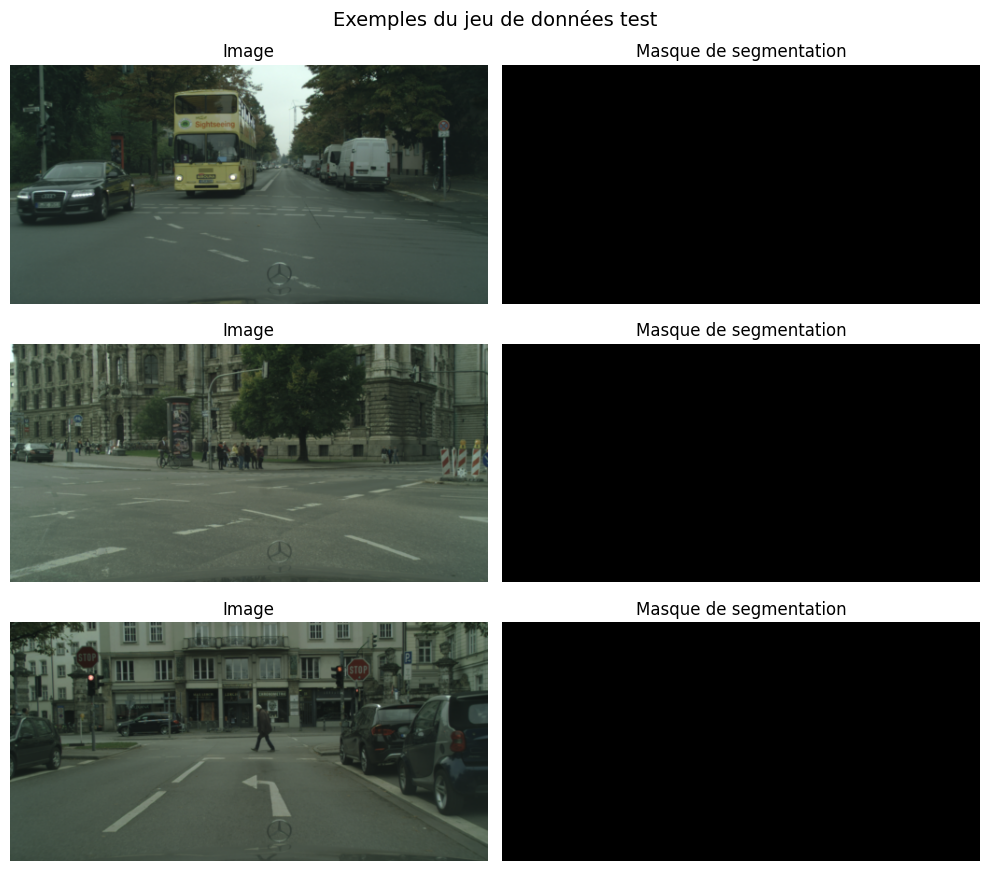


Légende sauvegardée à: /content/drive/MyDrive/openclassrooms/projets/p08-images-systeme-voiture-autonome/notebooks/content/data/samples/class_legend.png


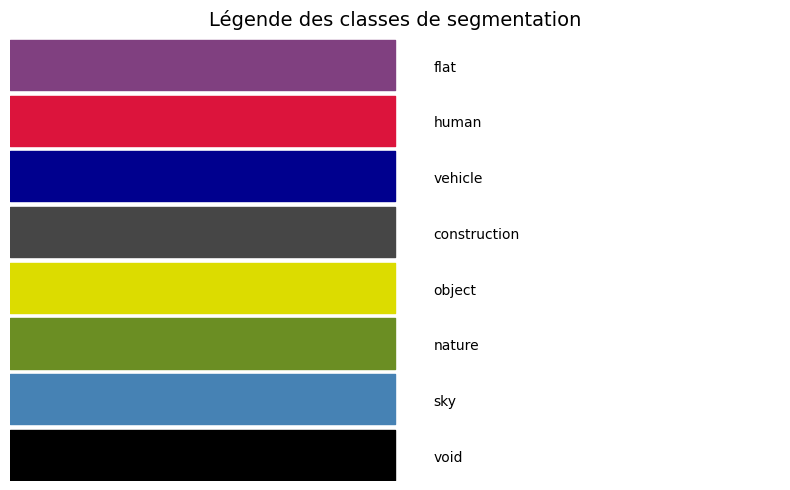

In [ ]:
def visualize_dataset_samples(root_dir, split='train', num_samples=3):
    """
    Visualise quelques exemples aléatoires du jeu de données avec leurs masques de segmentation

    Arguments:
        root_dir: Répertoire racine des données Cityscapes
        split: 'train' ou 'val'
        num_samples: Nombre d'échantillons à visualiser
    """
    # Chemins des répertoires
    images_dir = os.path.join(root_dir, 'leftImg8bit', split)
    masks_dir = os.path.join(root_dir, 'gtFine', split)

    # Listes pour stocker les chemins des images et des masques
    image_paths = []
    mask_paths = []

    # Parcourir les répertoires de villes pour trouver toutes les images
    for city in os.listdir(images_dir):
        city_img_dir = os.path.join(images_dir, city)
        city_mask_dir = os.path.join(masks_dir, city)

        for file_name in os.listdir(city_img_dir):
            if file_name.endswith('_leftImg8bit.png'):
                img_path = os.path.join(city_img_dir, file_name)
                mask_name = file_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                mask_path = os.path.join(city_mask_dir, mask_name)

                if os.path.exists(mask_path):
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)

    # Sélection aléatoire des images
    selected_indices = np.random.choice(len(image_paths), size=min(num_samples, len(image_paths)), replace=False)
    selected_img_paths = [image_paths[i] for i in selected_indices]
    selected_mask_paths = [mask_paths[i] for i in selected_indices]

    # Création d'une figure pour afficher les images et masques
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 3*num_samples))

    plt.suptitle(f"Exemples du jeu de données {split}", fontsize=14)

    for i, (img_path, mask_path) in enumerate(zip(selected_img_paths, selected_mask_paths)):
        # Chargement de l'image avec PIL (plus légère)
        img = np.array(Image.open(img_path).resize((512, 256), Image.BILINEAR))

        # Chargement du masque avec PIL
        mask_raw = np.array(Image.open(mask_path).resize((512, 256), Image.NEAREST))

        # Conversion du masque aux groupes définis
        mask = id_to_group[mask_raw]

        # Création du masque coloré
        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for class_idx in range(num_classes):
            colored_mask[mask == class_idx] = group_colors[class_idx]

        # Affichage
        if num_samples == 1:
            axes[0].imshow(img)
            axes[0].set_title("Image")
            axes[0].axis('off')

            axes[1].imshow(colored_mask)
            axes[1].set_title("Masque de segmentation")
            axes[1].axis('off')
        else:
            axes[i, 0].imshow(img)
            axes[i, 0].set_title("Image")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(colored_mask)
            axes[i, 1].set_title("Masque de segmentation")
            axes[i, 1].axis('off')

    plt.tight_layout()

    # Création du dossier pour les visualisations
    viz_dir = os.path.join(data_dir, 'samples')
    os.makedirs(viz_dir, exist_ok=True)

    # Sauvegarde de la figure
    fig_path = os.path.join(viz_dir, f'{split}_samples.png')
    fig.savefig(fig_path)

    print(f"Visualisation de {num_samples} échantillons du jeu de données {split}")
    print(f"Sauvegardé à: {fig_path}")

    return fig

# Visualisation de quelques échantillons du jeu d'entraînement
train_fig = visualize_dataset_samples(cityscapes_dir, split='train', num_samples=3)
plt.show()
plt.close(train_fig)
print()

# Visualisation de quelques échantillons du jeu de validation
val_fig = visualize_dataset_samples(cityscapes_dir, split='val', num_samples=3)
plt.show()
plt.close(val_fig)
print()

# Visualisation de quelques échantillons du jeu de test
test_fig = visualize_dataset_samples(cityscapes_dir, split='test', num_samples=3)
plt.show()
plt.close(test_fig)
print()

# Création de la légende des classes
def create_class_legend(class_names, class_colors, output_dir=None):
    """Crée une légende pour les classes de segmentation"""

    plt.figure(figsize=(8, 5))

    plt.title("Légende des classes de segmentation", fontsize=14)

    for i, (name, color) in enumerate(zip(class_names, class_colors)):
        plt.fill_between([0, 1], [i, i], [i+0.9, i+0.9], color=[c/255 for c in color])
        plt.text(1.1, i+0.5, name, va='center')

    plt.xlim(0, 2)
    plt.ylim(len(class_names)-0.1, -0.1)
    plt.axis('off')
    plt.tight_layout()

    if output_dir:
        legend_path = os.path.join(output_dir, 'class_legend.png')
        plt.savefig(legend_path)
        print(f"Légende sauvegardée à: {legend_path}")

    return plt.gcf()

# Création de la légende des classes
viz_dir = os.path.join(data_dir, 'samples')
legend_fig = create_class_legend(group_names, group_colors, output_dir=viz_dir)
plt.show()
plt.close(legend_fig)

## Architecture de Segmentation MobileNetV2-UNet


<img src="https://datascientest.com/wp-content/uploads/2021/05/u-net-architecture-1024x682.png" width="800" />

Cette architecture combine la puissance de MobileNetV2 (un réseau léger et efficace) avec la structure en forme de U de l'architecture U-Net pour réaliser une segmentation d'images. Voici une explication simple de cette architecture :

## Structure Générale

* **Forme en U** : L'architecture suit une forme en "U" avec une partie descendante (encodeur) et une partie ascendante (décodeur).
* **Objectif** : Attribuer une classe à chaque pixel de l'image (segmentation).

## Partie Encodeur (Descendante)

* **Base MobileNetV2** : On utilise MobileNetV2 comme encodeur, un réseau conçu pour être léger et efficace sur des appareils mobiles.
* **Couches gelées** : `base_model.trainable = False` - Les poids pré-entraînés de MobileNetV2 sont "gelés" pour accélérer l'entraînement initial.
* **Points de connexion** : On extrait les caractéristiques à différents niveaux de résolution :
  * skip1 : niveau 112×112
  * skip2 : niveau 56×56
  * skip3 : niveau 28×28
  * skip4 : niveau 14×14
  * bottleneck : niveau 7×7 (point le plus bas de l'architecture en U)

## Partie Décodeur (Ascendante)

* **Upsampling progressif** : On remonte progressivement de la résolution la plus basse à la résolution originale.
* **Connexions résiduelles (Skip connections)** : On connecte chaque niveau du décodeur avec le niveau correspondant de l'encodeur pour préserver les détails spatiaux.
* **Convolutions Transposes** : Utilisées pour augmenter la résolution à chaque étape :
  * 7×7 → 14×14
  * 14×14 → 28×28
  * 28×28 → 56×56
  * 56×56 → 112×112
  * 112×112 → 224×224

## Détails Techniques

* **Normalisation par lots (BatchNormalization)** : Après chaque couche de convolution pour stabiliser l'apprentissage.
* **Activation ReLU** : Fonction d'activation non-linéaire après chaque couche.
* **Concaténation** : Les caractéristiques du même niveau de l'encodeur sont concaténées avec celles du décodeur.
* **Couche finale** : Une convolution 1×1 avec activation softmax qui produit la probabilité d'appartenance à chaque classe pour chaque pixel.

## Avantages de cette Architecture

* **Efficacité** : MobileNetV2 est conçu pour être léger et rapide, idéal pour les applications mobiles.
* **Transfert d'apprentissage** : Utilise des poids pré-entraînés sur ImageNet pour de meilleures performances.
* **Préservation des détails** : Les connexions résiduelles permettent de conserver les informations spatiales importantes.
* **Adaptabilité** : Peut être utilisée pour différentes tâches de segmentation (comme la segmentation urbaine dans votre cas).

En résumé, cette architecture hybride combine l'efficacité de MobileNetV2 avec la capacité de U-Net à produire des segmentations précises, ce qui en fait un excellent choix pour la segmentation d'images dans des environnements avec des ressources limitées.



In [ ]:
# Configuration des expériences
# EXPERIMENT_CONFIG = {
#     "exp_name": "exp_002_baseline",  # Changez cette valeur pour chaque run
#     "description": "Baseline MobileNetV2-UNet avec frozen encoder",
#     "params": {
#         "learning_rate": 0.0001,
#         "batch_size": 8,
#         "epochs": 20,
#         "base_model_trainable": False,
#         "validation_split": 0.2,
#         "augmentation": True
#     }
# }

# Working model
EXPERIMENT_CONFIG = {
    "exp_name": "exp_001_baseline",  # Changez cette valeur pour chaque run
    "description": "Baseline MobileNetV2-UNet avec frozen encoder",
    "params": {
        "learning_rate": 0.0001,
        "batch_size": 8,
        "epochs": 20,
        "base_model_trainable": False,
        "validation_split": 0.2,
        "augmentation": True
    }
}


# Exemples d'autres configurations :
# EXPERIMENT_CONFIG = {
#     "exp_name": "exp_002_unfrozen",
#     "description": "MobileNetV2-UNet avec encoder trainable",
#     "params": {
#         "learning_rate": 0.00005,
#         "batch_size": 8,
#         "epochs": 20,
#         "base_model_trainable": True,
#         "validation_split": 0.2,
#         "augmentation": True
#     }
# }

In [ ]:
# Modification de la définition des chemins
def setup_experiment_paths(base_dir, experiment_name):
    """
    Crée la structure de dossiers pour une expérience
    """
    exp_dir = os.path.join(base_dir, "experiments", experiment_name)

    paths = {
        'exp_dir': exp_dir,
        'models_dir': os.path.join(exp_dir, 'models'),
        'checkpoints_dir': os.path.join(exp_dir, 'models', 'checkpoints'),
        'logs_dir': os.path.join(exp_dir, 'logs'),
        'results_dir': os.path.join(exp_dir, 'results'),
        'visualizations_dir': os.path.join(exp_dir, 'visualizations')
    }

    # Créer tous les dossiers
    for path in paths.values():
        os.makedirs(path, exist_ok=True)

    return paths

# Utilisation
exp_paths = setup_experiment_paths(g_drive_dir_content, EXPERIMENT_CONFIG["exp_name"])
print(f"Dossier d'expérience: {exp_paths['exp_dir']}")

Dossier d'expérience: /content/drive/MyDrive/openclassrooms/projets/p08-images-systeme-voiture-autonome/notebooks/content/experiments/exp_002_baseline


In [ ]:
# Sauvegarde de la config
# Chemin de sauvegarde
experiment_name = EXPERIMENT_CONFIG["exp_name"]
config_path = os.path.join(g_drive_dir_content, "experiments", experiment_name, "results", "experiment_config.json")

# Créer le dossier parent
os.makedirs(os.path.dirname(config_path), exist_ok=True)

# Sauvegarder
with open(config_path, 'w') as f:
    json.dump(EXPERIMENT_CONFIG, f, indent=4)

print(f"✅ Configuration sauvegardée: {config_path}")

In [ ]:
# Vérification - charger et afficher la config sauvegardée
def verify_experiment_config(experiment_name):
    config_path = os.path.join(g_drive_dir_content, "experiments", experiment_name, "results", "experiment_config.json")

    if os.path.exists(config_path):
        with open(config_path, 'r') as f:
            loaded_config = json.load(f)

        print(f"✅ Configuration chargée pour {experiment_name}:")
        print(json.dumps(loaded_config, indent=2))
        return loaded_config
    else:
        print(f"❌ Configuration non trouvée pour {experiment_name}")
        return None

# Test
verify_experiment_config("exp_001_baseline")

✅ Configuration chargée pour exp_001_baseline:
{
  "exp_name": "exp_001_baseline",
  "description": "Baseline MobileNetV2-UNet avec frozen encoder",
  "params": {
    "learning_rate": 0.0001,
    "batch_size": 8,
    "epochs": 20,
    "base_model_trainable": false,
    "validation_split": 0.2,
    "augmentation": true
  }
}


{'exp_name': 'exp_001_baseline',
 'description': 'Baseline MobileNetV2-UNet avec frozen encoder',
 'params': {'learning_rate': 0.0001,
  'batch_size': 8,
  'epochs': 20,
  'base_model_trainable': False,
  'validation_split': 0.2,
  'augmentation': True}}

### Création du modèle

In [ ]:
def create_segmentation_model(num_classes=8, input_size=(224, 224, 3),
                            learning_rate=0.0001, base_trainable=False):
    """
    Create a segmentation model with configurable parameters
    """
    # Input tensor
    inputs = keras.layers.Input(shape=input_size)

    # Create MobileNetV2 base model
    base_model = keras.applications.MobileNetV2(
        input_shape=input_size,
        include_top=False,
        weights='imagenet'
    )

    # Configuration de l'entraînement du modèle de base
    base_model.trainable = base_trainable

    # Create encoder using MobileNetV2
    # Get outputs at different levels for skip connections
    skip1 = base_model.get_layer('block_1_expand_relu').output      # 112x112
    skip2 = base_model.get_layer('block_3_expand_relu').output      # 56x56
    skip3 = base_model.get_layer('block_6_expand_relu').output      # 28x28
    skip4 = base_model.get_layer('block_13_expand_relu').output     # 14x14

    # Get bottleneck
    bottleneck = base_model.get_layer('block_16_project').output    # 7x7

    # Use Model API to create encoder model
    encoder = keras.Model(inputs=base_model.input, outputs=[skip1, skip2, skip3, skip4, bottleneck])

    # Encoder part - use the encoder model
    x = inputs
    skips = encoder(x)

    # Bottleneck
    x = skips[4]  # Use the bottleneck from encoder

    # Decoder part - upsampling and skip connections
    # First upsampling: 7x7 -> 14x14
    x = keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Concatenate()([x, skips[3]])
    x = keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)

    # Second upsampling: 14x14 -> 28x28
    x = keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Concatenate()([x, skips[2]])
    x = keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)

    # Third upsampling: 28x28 -> 56x56
    x = keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Concatenate()([x, skips[1]])
    x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)

    # Fourth upsampling: 56x56 -> 112x112
    x = keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Concatenate()([x, skips[0]])
    x = keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)

    # Final upsampling: 112x112 -> 224x224
    x = keras.layers.Conv2DTranspose(16, 3, strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(16, 3, padding='same', activation='relu')(x)

    # Output layer
    outputs = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(x)

    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs, name="MobileNetV2-UNet")

    # Compile model avec learning rate configurable
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(),
            # keras.metrics.MeanIoU(num_classes=num_classes)
        ]
    )

    return model

In [ ]:
# Create the model with compatible input size
model = create_segmentation_model(num_classes=num_classes, input_size=(img_size[0], img_size[1], 3))
print()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



Model: "MobileNetV2-UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 112, 112, │  1,841,984 │ input_layer[0][0] │
│ (Functional)        │ 96), (None, 56,   │            │                   │
│                     │ 56, 144), (None,  │            │                   │
│                     │ 28, 28, 192),     │            │                   │
│                     │ (None, 14, 14,    │            │                   │
│                     │ 576), (None, 7,   │            │                   │
│                     │ 7, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 14, 14,    │    737,536 │ functional[0][4]  │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 14, 14,    │      1,024 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14, 14,    │          0 │ activation[0][0], │
│ (Concatenate)       │ 832)              │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │  1,917,184 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 28, 28,    │    295,040 │ conv2d[0][0]      │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28,    │          0 │ activation_1[0][… │
│ (Concatenate)       │ 320)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │    368,768 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 56, 56,    │     73,792 │ conv2d_1[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                 

 Total params: 5,418,600 (20.67 MB)

 Trainable params: 3,575,624 (13.64 MB)

 Non-trainable params: 1,842,976 (7.03 MB)

### Visualisation de l'architecture du modèle

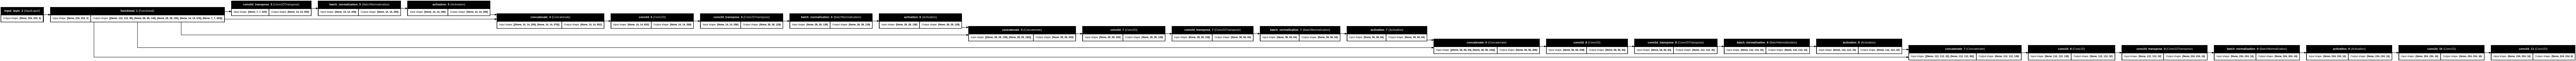

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Générer le diagramme
plot_model(
    model,
    to_file='unet_architecture.png',
    show_shapes=True,           # Affiche les dimensions des tenseurs
    show_layer_names=True,      # Affiche les noms des couches
    rankdir='LR',              # Layout horizontal (Left to Right)
    expand_nested=False,        # Développe les modèles imbriqués
    dpi=150                    # Résolution
)

# Afficher l'image
from IPython.display import Image
Image('unet_architecture_simple.png')

### Entraînement du modèle

In [ ]:
def train_model_with_config(model, train_dataset, val_dataset, config, paths):
    """
    Entraîne le modèle avec une configuration donnée
    """
    exp_name = config["exp_name"]
    params = config["params"]

    # Set up training callbacks avec les nouveaux chemins
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            verbose=1,
            min_lr=1e-6
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_sparse_categorical_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(paths['checkpoints_dir'], 'best_model.keras'),
            monitor='val_sparse_categorical_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        keras.callbacks.TensorBoard(
            log_dir=os.path.join(paths['logs_dir'], datetime.now().strftime('%Y%m%d-%H%M%S')),
            histogram_freq=1
        )
    ]

    # MLflow callback
    class ExperimentMLflowCallback(keras.callbacks.Callback):
        def __init__(self, config, paths):
            super().__init__()
            self.config = config
            self.paths = paths

        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            for name, value in logs.items():
                mlflow.log_metric(name, value, step=epoch)

        def on_train_begin(self, logs=None):
            # Log tous les paramètres de configuration
            mlflow.log_params(self.config["params"])
            mlflow.log_param("experiment_name", self.config["exp_name"])
            mlflow.log_param("description", self.config["description"])

    # Set up MLflow experiment
    mlflow.set_experiment("OC Projet 8")
    with mlflow.start_run(run_name=exp_name):
        # Add MLflow callback
        mlflow_callback = ExperimentMLflowCallback(config, paths)
        callbacks.append(mlflow_callback)

        # Train the model
        print(f"🚀 Starting training for experiment: {exp_name}")
        print(f"📝 Description: {config['description']}")
        print(f"📊 Parameters: {params}")

        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=params["epochs"],
            callbacks=callbacks,
            verbose=1
        )

        # Save artifacts dans le dossier de l'expérience
        save_experiment_artifacts(model, history, config, paths)

        # Log artifacts to MLflow
        mlflow.log_artifacts(paths['results_dir'])

        return history

def save_experiment_artifacts(model, history, config, paths):
    """
    Sauvegarde tous les artefacts de l'expérience
    """
    # 1. Sauvegarder le modèle final
    final_model_path = os.path.join(paths['models_dir'], "cityscapes_segmentation_model.keras")
    model.save(final_model_path)
    print(f"📁 Modèle sauvegardé: {final_model_path}")

    # 2. Sauvegarder la configuration
    config_path = os.path.join(paths['results_dir'], "experiment_config.json")
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)

    # 3. Sauvegarder l'historique d'entraînement
    history_path = os.path.join(paths['results_dir'], "training_history.json")
    with open(history_path, 'w') as f:
        # Convertir les numpy arrays en listes pour JSON
        history_dict = {}
        for key, values in history.history.items():
            history_dict[key] = [float(v) for v in values]
        json.dump(history_dict, f, indent=4)

    # 4. Créer et sauvegarder les graphiques
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    # Plot learning rate if available
    plt.subplot(1, 3, 3)
    if 'learning_rate' in history.history:
        plt.plot(history.history['learning_rate'])
        plt.title('Learning Rate')
        plt.ylabel('LR')
        plt.xlabel('Epoch')
    else:
        plt.text(0.5, 0.5, 'No LR data', ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plots_path = os.path.join(paths['visualizations_dir'], 'training_plots.png')
    plt.savefig(plots_path, dpi=300, bbox_inches='tight')
    plt.show()

    # 5. Sauvegarder le mapping des classes
    class_mapping = {
        'id_to_group': id_to_group.tolist(),
        'group_names': group_names,
        'group_colors': group_colors,
        'num_classes': num_classes
    }

    mapping_path = os.path.join(paths['models'], 'class_mapping.json')
    with open(mapping_path, 'w') as f:
        json.dump(class_mapping, f, indent=4)

    print(f"📊 Artefacts sauvegardés dans: {paths['exp_dir']}")

In [ ]:
# Code principal pour l'entraînement
TRAIN = False

if TRAIN:
    # 1. Setup de l'expérience
    exp_paths = setup_experiment_paths(g_drive_dir_content, EXPERIMENT_CONFIG["exp_name"])

    # 2. Créer le modèle avec les paramètres de configuration
    model = create_segmentation_model(
        num_classes=num_classes,
        input_size=(img_size[0], img_size[1], 3),
        learning_rate=EXPERIMENT_CONFIG["params"]["learning_rate"],
        base_trainable=EXPERIMENT_CONFIG["params"]["base_model_trainable"]
    )

    # 3. Préparer les datasets (peut aussi être configuré)
    batch_size = EXPERIMENT_CONFIG["params"]["batch_size"]

    train_dataset, val_dataset = prepare_dataset_with_split(
        cityscapes_dir,
        split='train',
        batch_size=batch_size,
        img_size=img_size,
        validation_split=EXPERIMENT_CONFIG["params"]["validation_split"]
    )

    # 4. Entraîner le modèle
    history = train_model_with_config(model, train_dataset, val_dataset, EXPERIMENT_CONFIG, exp_paths)

    print(f"✅ Expérience {EXPERIMENT_CONFIG['exp_name']} terminée!")
    print(f"📁 Résultats dans: {exp_paths['exp_dir']}")

In [ ]:
# @title
# WORKS

# TRAIN = False

# if TRAIN:

#   # Set up training callbacks
#   callbacks = [
#       # Reduce learning rate when plateauing
#       keras.callbacks.ReduceLROnPlateau(
#           monitor='val_loss',
#           factor=0.2,
#           patience=2,
#           verbose=1,
#           min_lr=1e-6
#       ),
#       # Early stopping
#       keras.callbacks.EarlyStopping(
#           monitor='val_sparse_categorical_accuracy',  # Changed from val_mean_io_u
#           patience=5,
#           restore_best_weights=True,
#           verbose=1,
#           mode='max'
#       ),
#       # Save best model
#       keras.callbacks.ModelCheckpoint(
#           filepath=os.path.join(g_drive_dir_content, 'models', 'checkpoints', 'best_model.keras'),
#           monitor='val_sparse_categorical_accuracy',  # Changed from val_mean_io_u
#           save_best_only=True,
#           mode='max',
#           verbose=1
#       ),
#       # TensorBoard visualization
#       keras.callbacks.TensorBoard(
#           log_dir=os.path.join(g_drive_dir_content, 'logs', datetime.now().strftime('%Y%m%d-%H%M%S')),
#           histogram_freq=1
#       )
#   ]

#   # Custom simple MLflow callback without complex metrics
#   class SimpleMLflowCallback(keras.callbacks.Callback):
#       def on_epoch_end(self, epoch, logs=None):
#           logs = logs or {}
#           for name, value in logs.items():
#               mlflow.log_metric(name, value, step=epoch)

#       def on_train_begin(self, logs=None):
#           mlflow.log_params({
#               "model_type": "MobileNetV2-UNet",
#               "num_classes": num_classes,
#               "batch_size": batch_size,
#               "img_size": img_size,
#               "optimizer": "Adam",
#               "learning_rate": 0.0001
#           })

#   # Set up MLflow experiment
#   mlflow.set_experiment("OC Projet 8")
#   with mlflow.start_run(run_name="MobileNetV2-UNet"):
#       # Add MLflow callback
#       mlflow_callback = SimpleMLflowCallback()
#       callbacks.append(mlflow_callback)

#       # Train the model
#       print("Starting model training...")
#       history = model.fit(
#           train_dataset,
#           validation_data=val_dataset,
#           epochs=20,
#           callbacks=callbacks,
#           verbose=1
#       )

#       # Save the final model
#       final_model_path = os.path.join(g_drive_dir_content, "models", "cityscapes_segmentation_model.keras")
#       model.save(final_model_path)
#       print(f"Final model saved to: {final_model_path}")

#       # Log the model to MLflow
#       mlflow.keras.log_model(model, "model")

#       # Save class mapping
#       class_mapping = {
#           'id_to_group': id_to_group.tolist(),
#           'group_names': group_names,
#           'group_colors': group_colors,
#           'num_classes': num_classes
#       }

#       mapping_path = os.path.join(g_drive_dir_content, 'models', 'class_mapping.json')
#       with open(mapping_path, 'w') as f:
#           json.dump(class_mapping, f, indent=4)

#       # Log the mapping file as an artifact
#       mlflow.log_artifact(mapping_path)

#   # Plot training history
#   plt.figure(figsize=(12, 5))

#   # Plot loss
#   plt.subplot(1, 2, 1)
#   plt.plot(history.history['loss'])
#   plt.plot(history.history['val_loss'])
#   plt.title('Model Loss')
#   plt.ylabel('Loss')
#   plt.xlabel('Epoch')
#   plt.legend(['Train', 'Validation'], loc='upper right')

#   # Plot accuracy
#   plt.subplot(1, 2, 2)
#   plt.plot(history.history['sparse_categorical_accuracy'])
#   plt.plot(history.history['val_sparse_categorical_accuracy'])
#   plt.title('Model Accuracy')
#   plt.ylabel('Accuracy')
#   plt.xlabel('Epoch')
#   plt.legend(['Train', 'Validation'], loc='lower right')

#   plt.tight_layout()
#   plt.savefig(os.path.join(g_drive_dir_content, 'training_history.png'))
#   plt.show()

#   print("Training complete!")

## Évaluation du modèle

In [ ]:
experiment_name = "OC Projet 8"
original_run_id = "460450247b12489085648f47b249a379"

In [ ]:
def load_and_evaluate_experiment(experiment_name, test_dataset, base_dir):
    """
    Charge un modèle d'expérience et l'évalue sur le dataset de test

    Args:
        experiment_name: Nom de l'expérience (ex: "exp_001_baseline")
        test_dataset: Dataset de test
        base_dir: Répertoire de base des expériences

    Returns:
        dict: Résultats de l'évaluation
    """
    model_path = os.path.join(base_dir, "experiments", experiment_name, "models", "cityscapes_segmentation_model.keras")

    print(f"📁 Chargement du modèle depuis: {experiment_name}")

    # Charger le modèle
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Modèle non trouvé: {model_path}")

    model = tf.keras.models.load_model(model_path)
    print(f"✅ Modèle chargé avec succès!")

    # Charger la configuration
    config_path = os.path.join(base_dir, "experiments", experiment_name, "results", "experiment_config.json")
    if os.path.exists(config_path):
        with open(config_path, 'r') as f:
            config = json.load(f)
        print(f"   Description: {config.get('description', 'N/A')}")

    # Évaluer
    print(f"\n🧪 Évaluation sur le dataset de test...")
    test_results = model.evaluate(test_dataset, verbose=1)

    # Préparer les résultats
    results_dict = {}
    for metric_name, value in zip(model.metrics_names, test_results):
        results_dict[f"test_{metric_name}"] = float(value)
        print(f"   {metric_name}: {value:.4f}")

    # Sauvegarder les résultats
    test_results_path = os.path.join(base_dir, "experiments", experiment_name, "results", "test_results.json")
    with open(test_results_path, 'w') as f:
        json.dump({
            'test_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'results': results_dict
        }, f, indent=4)

    return results_dict, model

# Utilisation
results, trained_model = load_and_evaluate_experiment("exp_001_baseline", test_dataset, g_drive_dir_content)

🔍 ÉVALUATION DÉTAILLÉE DU MODÈLE
📁 Répertoire de sauvegarde: /content/drive/MyDrive/openclassrooms/projets/p08-images-systeme-voiture-autonome/notebooks/content/experiments/exp_001_baseline/results

📊 1. MÉTRIQUES DE BASE
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 529ms/step - loss: 0.4089 - sparse_categorical_accuracy: 0.8761

📋 Métriques de base:
       Métrique  Valeur
           loss  0.4123
compile_metrics  0.8795
💾 Sauvegardé: /content/drive/MyDrive/openclassrooms/projets/p08-images-systeme-voiture-autonome/notebooks/content/experiments/exp_001_baseline/results/base_metrics.csv

🎯 2. COLLECTE DES PRÉDICTIONS
   Traitement des batches...
   Batch 1 traité...
   Batch 11 traité...
   Batch 21 traité...
   Batch 31 traité...
   Batch 41 traité...
   Batch 51 traité...
   Batch 61 traité...
   Total d'images évaluées: 500

📈 3. IoU (INTERSECTION OVER UNION) PAR CLASSE

📊 Tableau IoU par classe:
      Classe    IoU  Pixels_Vrais  Pixels_Vrais_%  Pixels_Prédits  Pixels_Prédits_%  Intersection    U

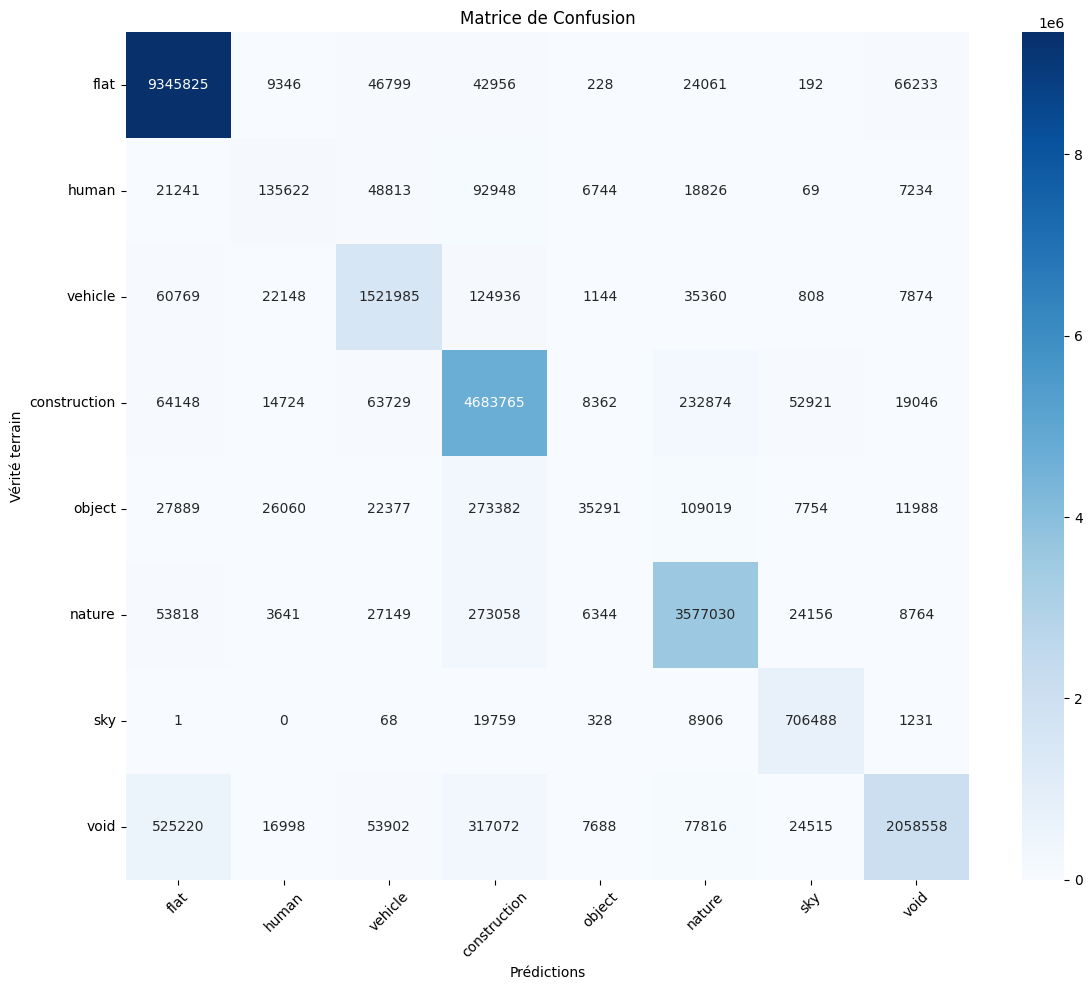


🖼️ 6. EXEMPLES DE PRÉDICTIONS
🖼️ Exemples de prédictions sauvegardés: /content/drive/MyDrive/openclassrooms/projets/p08-images-systeme-voiture-autonome/notebooks/content/experiments/exp_001_baseline/results/prediction_examples.png


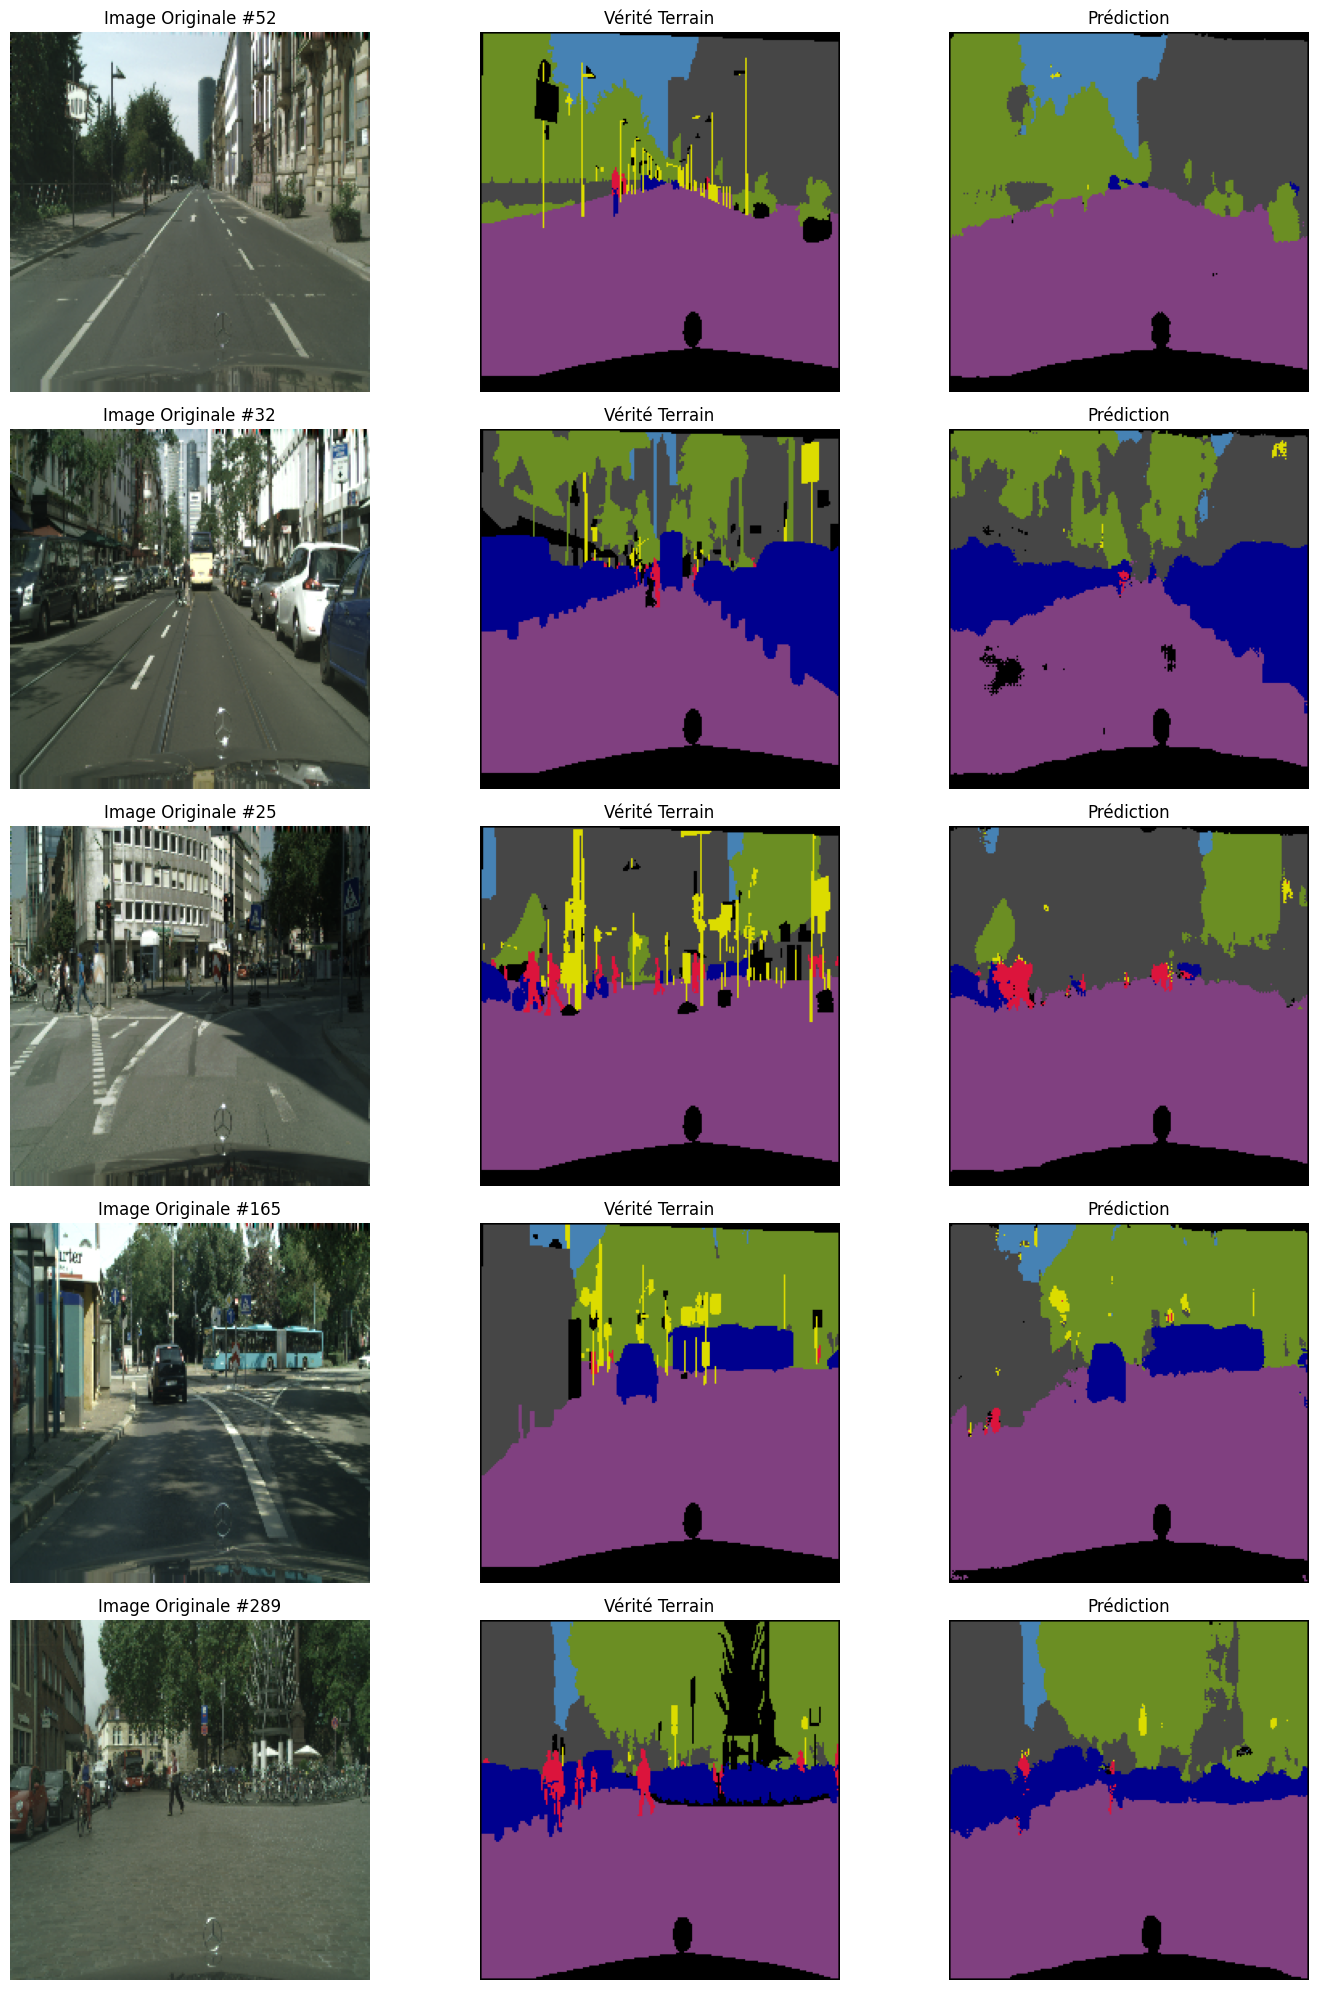


📝 7. RÉSUMÉ FINAL

📊 Résumé final:
                Métrique              Valeur
       Précision globale              0.8795
                Mean IoU              0.6325
  Meilleure classe (IoU)       flat (0.9084)
       Pire classe (IoU)     object (0.0648)
Nombre d'images évaluées                 500
       Date d'évaluation 2025-05-23 09:11:19
💾 Sauvegardé: /content/drive/MyDrive/openclassrooms/projets/p08-images-systeme-voiture-autonome/notebooks/content/experiments/exp_001_baseline/results/evaluation_summary.csv

✅ Évaluation terminée. Tous les fichiers sauvegardés dans: /content/drive/MyDrive/openclassrooms/projets/p08-images-systeme-voiture-autonome/notebooks/content/experiments/exp_001_baseline/results

🎯 Accès aux DataFrames:
- results['dataframes']['base_metrics']
- results['dataframes']['iou_per_class']
- results['dataframes']['classification_report']
- results['dataframes']['confusion_matrix']
- results['dataframes']['summary']


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

def detailed_evaluation(model, test_dataset, class_names, class_colors, experiment_name=None, save_dir=None):
    """
    Évaluation détaillée du modèle avec métriques complètes
    """
    # Définir le répertoire de sauvegarde
    if save_dir is None and experiment_name:
        save_dir = os.path.join(g_drive_dir_content, "experiments", experiment_name, "results")
    elif save_dir is None:
        save_dir = os.path.join(g_drive_dir_content, "evaluation_results")

    os.makedirs(save_dir, exist_ok=True)

    print("🔍 ÉVALUATION DÉTAILLÉE DU MODÈLE")
    print("=" * 50)
    print(f"📁 Répertoire de sauvegarde: {save_dir}")

    # 1. Métriques de base
    print("\n📊 1. MÉTRIQUES DE BASE")
    test_results = model.evaluate(test_dataset, verbose=1)

    # Créer DataFrame pour les métriques de base
    base_metrics_df = pd.DataFrame({
        'Métrique': model.metrics_names,
        'Valeur': test_results
    })

    print("\n📋 Métriques de base:")
    print(base_metrics_df.to_string(index=False, float_format='%.4f'))

    # Sauvegarder les métriques de base
    base_metrics_path = os.path.join(save_dir, "base_metrics.csv")
    base_metrics_df.to_csv(base_metrics_path, index=False)
    print(f"💾 Sauvegardé: {base_metrics_path}")

    # 2. Calcul de l'IoU par classe et métriques détaillées
    print("\n🎯 2. COLLECTE DES PRÉDICTIONS")

    all_true_masks = []
    all_pred_masks = []
    all_images = []

    # Collecter toutes les prédictions
    print("   Traitement des batches...")
    for batch_idx, (images, true_masks) in enumerate(test_dataset):
        predictions = model.predict(images, verbose=0)
        pred_masks = tf.argmax(predictions, axis=-1)

        all_images.extend(images.numpy())
        all_true_masks.extend(true_masks.numpy())
        all_pred_masks.extend(pred_masks.numpy())

        if batch_idx % 10 == 0:
            print(f"   Batch {batch_idx + 1} traité...")

    # Convertir en arrays numpy
    all_true_masks = np.array(all_true_masks)
    all_pred_masks = np.array(all_pred_masks)
    all_images = np.array(all_images)

    print(f"   Total d'images évaluées: {len(all_true_masks)}")

    # 3. IoU par classe
    print("\n📈 3. IoU (INTERSECTION OVER UNION) PAR CLASSE")

    iou_data = []
    ious = []

    for class_id in range(len(class_names)):
        # Masques binaires pour cette classe
        true_binary = (all_true_masks == class_id)
        pred_binary = (all_pred_masks == class_id)

        # Calcul IoU
        intersection = np.logical_and(true_binary, pred_binary).sum()
        union = np.logical_or(true_binary, pred_binary).sum()

        if union > 0:
            iou = intersection / union
        else:
            iou = 0.0  # Classe absente

        ious.append(iou)

        # Statistiques de présence
        true_pixels = true_binary.sum()
        pred_pixels = pred_binary.sum()
        total_pixels = all_true_masks.size

        iou_data.append({
            'Classe': class_names[class_id],
            'IoU': iou,
            'Pixels_Vrais': true_pixels,
            'Pixels_Vrais_%': 100 * true_pixels / total_pixels,
            'Pixels_Prédits': pred_pixels,
            'Pixels_Prédits_%': 100 * pred_pixels / total_pixels,
            'Intersection': intersection,
            'Union': union
        })

    # Créer DataFrame pour IoU
    iou_df = pd.DataFrame(iou_data)
    mean_iou = np.mean(ious)

    print("\n📊 Tableau IoU par classe:")
    print(iou_df.to_string(index=False, float_format='%.4f'))
    print(f"\n📊 MEAN IoU: {mean_iou:.4f}")

    # Sauvegarder IoU
    iou_path = os.path.join(save_dir, "iou_per_class.csv")
    iou_df.to_csv(iou_path, index=False)
    print(f"💾 Sauvegardé: {iou_path}")

    # 4. Rapport de classification détaillé
    print("\n📋 4. RAPPORT DE CLASSIFICATION")

    # Aplatir les masques pour sklearn
    y_true_flat = all_true_masks.flatten()
    y_pred_flat = all_pred_masks.flatten()

    # Rapport de classification
    report = classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )

    # Créer DataFrame pour le rapport de classification
    classification_data = []

    for class_name in class_names:
        if class_name in report:
            metrics = report[class_name]
            classification_data.append({
                'Classe': class_name,
                'Précision': metrics['precision'],
                'Rappel': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': int(metrics['support'])
            })

    # Ajouter les métriques globales
    classification_data.append({
        'Classe': 'Accuracy',
        'Précision': report['accuracy'],
        'Rappel': None,
        'F1-Score': None,
        'Support': y_true_flat.shape[0]
    })

    classification_data.append({
        'Classe': 'Macro avg',
        'Précision': report['macro avg']['precision'],
        'Rappel': report['macro avg']['recall'],
        'F1-Score': report['macro avg']['f1-score'],
        'Support': int(report['macro avg']['support'])
    })

    classification_data.append({
        'Classe': 'Weighted avg',
        'Précision': report['weighted avg']['precision'],
        'Rappel': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'Support': int(report['weighted avg']['support'])
    })

    classification_df = pd.DataFrame(classification_data)

    print("\n📊 Rapport de classification:")
    print(classification_df.to_string(index=False, float_format='%.4f'))

    # Sauvegarder le rapport de classification
    classification_path = os.path.join(save_dir, "classification_report.csv")
    classification_df.to_csv(classification_path, index=False)
    print(f"💾 Sauvegardé: {classification_path}")

    # 5. Matrice de confusion
    print("\n🔢 5. MATRICE DE CONFUSION")
    cm = confusion_matrix(y_true_flat, y_pred_flat)

    # Créer DataFrame pour la matrice de confusion
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    print("\n📊 Matrice de confusion:")
    print(cm_df.to_string())

    # Sauvegarder la matrice de confusion
    cm_path = os.path.join(save_dir, "confusion_matrix.csv")
    cm_df.to_csv(cm_path)
    print(f"💾 Sauvegardé: {cm_path}")

    # Visualiser et sauvegarder la matrice de confusion
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matrice de Confusion')
    plt.xlabel('Prédictions')
    plt.ylabel('Vérité terrain')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Sauvegarder la visualisation
    cm_viz_path = os.path.join(save_dir, "confusion_matrix.png")
    plt.savefig(cm_viz_path, dpi=300, bbox_inches='tight')
    print(f"🖼️ Visualisation sauvegardée: {cm_viz_path}")
    plt.show()

    # 6. Visualisation des prédictions
    print("\n🖼️ 6. EXEMPLES DE PRÉDICTIONS")
    visualize_predictions_detailed(all_images, all_true_masks, all_pred_masks,
                                 class_names, class_colors, num_samples=5, save_dir=save_dir)

    # 7. Résumé final
    print("\n📝 7. RÉSUMÉ FINAL")

    summary_data = {
        'Métrique': [
            'Précision globale',
            'Mean IoU',
            'Meilleure classe (IoU)',
            'Pire classe (IoU)',
            'Nombre d\'images évaluées',
            'Date d\'évaluation'
        ],
        'Valeur': [
            f"{report['accuracy']:.4f}",
            f"{mean_iou:.4f}",
            f"{class_names[np.argmax(ious)]} ({max(ious):.4f})",
            f"{class_names[np.argmin(ious)]} ({min(ious):.4f})",
            f"{len(all_true_masks)}",
            datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        ]
    }

    summary_df = pd.DataFrame(summary_data)

    print("\n📊 Résumé final:")
    print(summary_df.to_string(index=False))

    # Sauvegarder le résumé
    summary_path = os.path.join(save_dir, "evaluation_summary.csv")
    summary_df.to_csv(summary_path, index=False)
    print(f"💾 Sauvegardé: {summary_path}")

    # Créer un DataFrame récapitulatif de tous les résultats
    recap_data = {
        'accuracy': report['accuracy'],
        'mean_iou': mean_iou,
        'class_ious': dict(zip(class_names, ious)),
        'classification_report': report,
        'confusion_matrix': cm,
        'dataframes': {
            'base_metrics': base_metrics_df,
            'iou_per_class': iou_df,
            'classification_report': classification_df,
            'confusion_matrix': cm_df,
            'summary': summary_df
        }
    }

    print(f"\n✅ Évaluation terminée. Tous les fichiers sauvegardés dans: {save_dir}")

    return recap_data

def visualize_predictions_detailed(images, true_masks, pred_masks, class_names, class_colors, num_samples=5, save_dir=None):
    """Visualise des exemples de prédictions avec comparaison et sauvegarde"""

    # Sélectionner des échantillons aléatoirement
    indices = np.random.choice(len(images), size=min(num_samples, len(images)), replace=False)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))

    for i, idx in enumerate(indices):
        # Image originale
        axes[i, 0].imshow((images[idx] * 255).astype(np.uint8))
        axes[i, 0].set_title(f"Image Originale #{idx}")
        axes[i, 0].axis('off')

        # Masque vrai
        true_colored = np.zeros((*true_masks[idx].shape, 3), dtype=np.uint8)
        for class_id in range(len(class_names)):
            true_colored[true_masks[idx] == class_id] = class_colors[class_id]

        axes[i, 1].imshow(true_colored)
        axes[i, 1].set_title("Vérité Terrain")
        axes[i, 1].axis('off')

        # Masque prédit
        pred_colored = np.zeros((*pred_masks[idx].shape, 3), dtype=np.uint8)
        for class_id in range(len(class_names)):
            pred_colored[pred_masks[idx] == class_id] = class_colors[class_id]

        axes[i, 2].imshow(pred_colored)
        axes[i, 2].set_title("Prédiction")
        axes[i, 2].axis('off')

    plt.tight_layout()

    # Sauvegarder la visualisation
    if save_dir:
        predictions_viz_path = os.path.join(save_dir, "prediction_examples.png")
        plt.savefig(predictions_viz_path, dpi=300, bbox_inches='tight')
        print(f"🖼️ Exemples de prédictions sauvegardés: {predictions_viz_path}")

    plt.show()

# Lancer l'évaluation détaillée avec sauvegarde
experiment_name = "exp_001_baseline"  # Remplacez par votre nom d'expérience
results = detailed_evaluation(
    trained_model,
    test_dataset,
    group_names,
    group_colors,
    experiment_name=experiment_name
)

print("\n🎯 Accès aux DataFrames:")
print("- results['dataframes']['base_metrics']")
print("- results['dataframes']['iou_per_class']")
print("- results['dataframes']['classification_report']")
print("- results['dataframes']['confusion_matrix']")
print("- results['dataframes']['summary']")

## Comparaison des experiences

In [ ]:
def compare_experiments(base_dir):
    """
    Compare les résultats de plusieurs expériences
    """
    experiments_dir = os.path.join(base_dir, "experiments")

    if not os.path.exists(experiments_dir):
        print("Aucune expérience trouvée")
        return

    results = []

    for exp_name in os.listdir(experiments_dir):
        exp_path = os.path.join(experiments_dir, exp_name)
        config_path = os.path.join(exp_path, "results", "experiment_config.json")
        history_path = os.path.join(exp_path, "results", "training_history.json")

        if os.path.exists(config_path) and os.path.exists(history_path):
            with open(config_path, 'r') as f:
                config = json.load(f)
            with open(history_path, 'r') as f:
                history = json.load(f)

            # Extraire les métriques finales
            final_metrics = {
                'experiment': exp_name,
                'description': config.get('description', ''),
                'final_train_acc': history['sparse_categorical_accuracy'][-1],
                'final_val_acc': history['val_sparse_categorical_accuracy'][-1],
                'final_train_loss': history['loss'][-1],
                'final_val_loss': history['val_loss'][-1],
                'best_val_acc': max(history['val_sparse_categorical_accuracy']),
                'epochs_trained': len(history['loss'])
            }
            results.append(final_metrics)

    # Afficher les résultats
    if results:
        print("\n🏆 COMPARAISON DES EXPÉRIENCES")
        print("=" * 80)
        for result in sorted(results, key=lambda x: x['best_val_acc'], reverse=True):
            print(f"📊 {result['experiment']}")
            print(f"   Description: {result['description']}")
            print(f"   Meilleure Val Acc: {result['best_val_acc']:.4f}")
            print(f"   Val Acc finale: {result['final_val_acc']:.4f}")
            print(f"   Époques: {result['epochs_trained']}")
            print()

# Utilisation pour comparer
# compare_experiments(g_drive_dir_content)

## Fonction d'inférence et démonstration

In [ ]:
def load_model_and_config(experiment_name, base_dir=None):
    """
    Charge le modèle et la configuration depuis une expérience

    Args:
        experiment_name: Nom de l'expérience (ex: "exp_001_baseline")
        base_dir: Répertoire de base (par défaut: g_drive_dir_content)

    Returns:
        tuple: (model, config_dict) où config_dict contient le mapping des classes
    """
    if base_dir is None:
        base_dir = g_drive_dir_content

    # Chemins vers les fichiers
    model_path = os.path.join(base_dir, "experiments", experiment_name, "models", "cityscapes_segmentation_model.keras")
    config_path = os.path.join(base_dir, "experiments", experiment_name, "models", "class_mapping.json")

    print(f"📁 Chargement depuis l'expérience: {experiment_name}")

    # Vérifier l'existence des fichiers
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Modèle non trouvé: {model_path}")

    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Configuration non trouvée: {config_path}")

    # Charger le modèle
    print(f"🤖 Chargement du modèle...")
    model = tf.keras.models.load_model(model_path)
    print(f"✅ Modèle chargé: {model.name}")
    print(f"   Paramètres: {model.count_params():,}")

    # Charger la configuration
    print(f"⚙️  Chargement de la configuration...")
    with open(config_path, 'r') as f:
        config = json.load(f)

    # Reconstruire les variables importantes
    config['id_to_group'] = np.array(config['id_to_group'], dtype=np.uint8)

    print(f"✅ Configuration chargée:")
    print(f"   Classes: {config['num_classes']}")
    print(f"   Groupes: {config['group_names']}")

    return model, config

In [ ]:
def predict_single_image(model, config, image_path=None, image_array=None, img_size=(224, 224)):
    """
    Réalise une prédiction sur une seule image

    Args:
        model: Modèle TensorFlow/Keras chargé
        config: Configuration avec mapping des classes
        image_path: Chemin vers l'image (optionnel)
        image_array: Array numpy de l'image (optionnel)
        img_size: Taille de redimensionnement

    Returns:
        dict: Dictionnaire avec l'image, la prédiction, et les statistiques
    """
    # Validation des entrées
    if image_path is None and image_array is None:
        raise ValueError("Il faut fournir soit image_path soit image_array")

    if image_path is not None and image_array is not None:
        raise ValueError("Ne fournir qu'un seul type d'entrée: image_path OU image_array")

    # Charger l'image
    if image_path is not None:
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image non trouvée: {image_path}")

        print(f"📷 Chargement de l'image: {os.path.basename(image_path)}")

        # Charger avec PIL puis convertir
        image_pil = Image.open(image_path).convert('RGB')
        image_array = np.array(image_pil)

    # Préprocessing de l'image
    print(f"🔄 Préprocessing de l'image...")
    print(f"   Taille originale: {image_array.shape}")

    # Redimensionner
    image_resized = tf.image.resize(image_array, img_size, method='bilinear')

    # Normaliser [0,1]
    image_normalized = tf.cast(image_resized, tf.float32) / 255.0

    # Ajouter dimension batch
    image_batch = tf.expand_dims(image_normalized, axis=0)

    print(f"   Taille pour prédiction: {image_batch.shape}")

    # Faire la prédiction
    print(f"🧠 Prédiction en cours...")
    predictions = model.predict(image_batch, verbose=0)

    # Convertir en masque de classes
    pred_mask = tf.argmax(predictions, axis=-1)[0].numpy()  # Enlever dimension batch

    # Calcul des statistiques
    unique_classes, counts = np.unique(pred_mask, return_counts=True)
    total_pixels = pred_mask.size

    class_stats = []
    for class_id, count in zip(unique_classes, counts):
        class_name = config['group_names'][class_id]
        percentage = (count / total_pixels) * 100
        class_stats.append({
            'class_id': int(class_id),
            'class_name': class_name,
            'pixel_count': int(count),
            'percentage': percentage
        })

    # Trier par pourcentage décroissant
    class_stats.sort(key=lambda x: x['percentage'], reverse=True)

    print(f"✅ Prédiction terminée!")
    print(f"📊 Classes détectées:")
    for stat in class_stats:
        print(f"   {stat['class_name']:>12}: {stat['pixel_count']:>8} pixels ({stat['percentage']:>5.1f}%)")

    return {
        'original_image': image_array,
        'processed_image': image_normalized.numpy(),
        'predictions_raw': predictions[0],  # ← Correction: enlever .numpy()
        'prediction_mask': pred_mask,
        'class_statistics': class_stats,
        'image_path': image_path,
        'input_size': img_size
    }

In [ ]:
def predict_from_test_dataset(model, config, test_dataset, image_index=0):
    """
    Fait une prédiction sur une image du dataset de test

    Args:
        model: Modèle chargé
        config: Configuration
        test_dataset: Dataset de test
        image_index: Index de l'image dans le dataset

    Returns:
        dict: Résultat de prédiction avec vérité terrain
    """
    # Extraire l'image du dataset
    for batch_idx, (images, true_masks) in enumerate(test_dataset):
        batch_start = batch_idx * images.shape[0]
        batch_end = batch_start + images.shape[0]

        if batch_start <= image_index < batch_end:
            # Image trouvée dans ce batch
            local_idx = image_index - batch_start
            image = images[local_idx].numpy()
            true_mask = true_masks[local_idx].numpy()

            print(f"📷 Image extraite du dataset (index {image_index})")

            # Faire la prédiction (l'image est déjà préprocessée)
            image_for_pred = tf.expand_dims(images[local_idx], axis=0)
            predictions = model.predict(image_for_pred, verbose=0)
            pred_mask = tf.argmax(predictions, axis=-1)[0].numpy()

            # Statistiques de la prédiction
            unique_pred, counts_pred = np.unique(pred_mask, return_counts=True)
            unique_true, counts_true = np.unique(true_mask, return_counts=True)
            total_pixels = pred_mask.size

            class_stats = []
            for class_id in range(config['num_classes']):
                pred_count = counts_pred[unique_pred == class_id][0] if class_id in unique_pred else 0
                true_count = counts_true[unique_true == class_id][0] if class_id in unique_true else 0

                class_stats.append({
                    'class_id': int(class_id),
                    'class_name': config['group_names'][class_id],
                    'predicted_pixels': int(pred_count),
                    'true_pixels': int(true_count),
                    'predicted_percentage': (pred_count / total_pixels) * 100,
                    'true_percentage': (true_count / total_pixels) * 100
                })

            return {
                'original_image': (image * 255).astype(np.uint8),  # Dénormaliser pour affichage
                'prediction_mask': pred_mask,
                'true_mask': true_mask,
                'predictions_raw': predictions[0],  # ← Correction: enlever .numpy()
                'class_statistics': class_stats,
                'image_index': image_index
            }

    raise IndexError(f"Image index {image_index} non trouvé dans le dataset")

In [ ]:
def visualize_prediction(prediction_result, config, save_path=None):
    """
    Visualise le résultat d'une prédiction

    Args:
        prediction_result: Résultat de predict_single_image()
        config: Configuration avec les couleurs des classes
        save_path: Chemin de sauvegarde (optionnel)
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Image originale
    axes[0].imshow(prediction_result['original_image'])
    axes[0].set_title("Image Originale")
    axes[0].axis('off')

    # Masque de prédiction (colormap)
    im = axes[1].imshow(prediction_result['prediction_mask'], cmap='tab10',
                       vmin=0, vmax=config['num_classes']-1)
    axes[1].set_title("Prédiction (ID Classes)")
    axes[1].axis('off')

    # Ajouter une colorbar
    cbar = plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    cbar.set_ticks(range(config['num_classes']))
    cbar.set_ticklabels(config['group_names'])

    # Masque coloré avec les vraies couleurs
    pred_colored = np.zeros((*prediction_result['prediction_mask'].shape, 3), dtype=np.uint8)
    for class_id in range(config['num_classes']):
        mask = prediction_result['prediction_mask'] == class_id
        pred_colored[mask] = config['group_colors'][class_id]

    axes[2].imshow(pred_colored)
    axes[2].set_title("Prédiction (Colorée)")
    axes[2].axis('off')

    # Titre général avec statistiques
    top_class = prediction_result['class_statistics'][0]
    plt.suptitle(f"Prédiction - Classe dominante: {top_class['class_name']} ({top_class['percentage']:.1f}%)",
                fontsize=14)

    plt.tight_layout()

    # Sauvegarder si demandé
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"🖼️ Visualisation sauvegardée: {save_path}")

    plt.show()

    # Afficher le tableau des statistiques
    stats_df = pd.DataFrame(prediction_result['class_statistics'])
    print("\n📊 Statistiques détaillées:")
    print(stats_df[['class_name', 'pixel_count', 'percentage']].to_string(index=False, float_format='%.2f'))

In [ ]:
# 1. Charger le modèle et la configuration
experiment_name = "exp_001_baseline"
model, config = load_model_and_config(experiment_name)

📁 Chargement depuis l'expérience: exp_001_baseline
🤖 Chargement du modèle...
✅ Modèle chargé: MobileNetV2-UNet
   Paramètres: 5,418,600
⚙️  Chargement de la configuration...
✅ Configuration chargée:
   Classes: 8
   Groupes: ['flat', 'human', 'vehicle', 'construction', 'object', 'nature', 'sky', 'void']



PRÉDICTION SUR IMAGE DU DATASET DE TEST
📷 Image extraite du dataset (index 5)


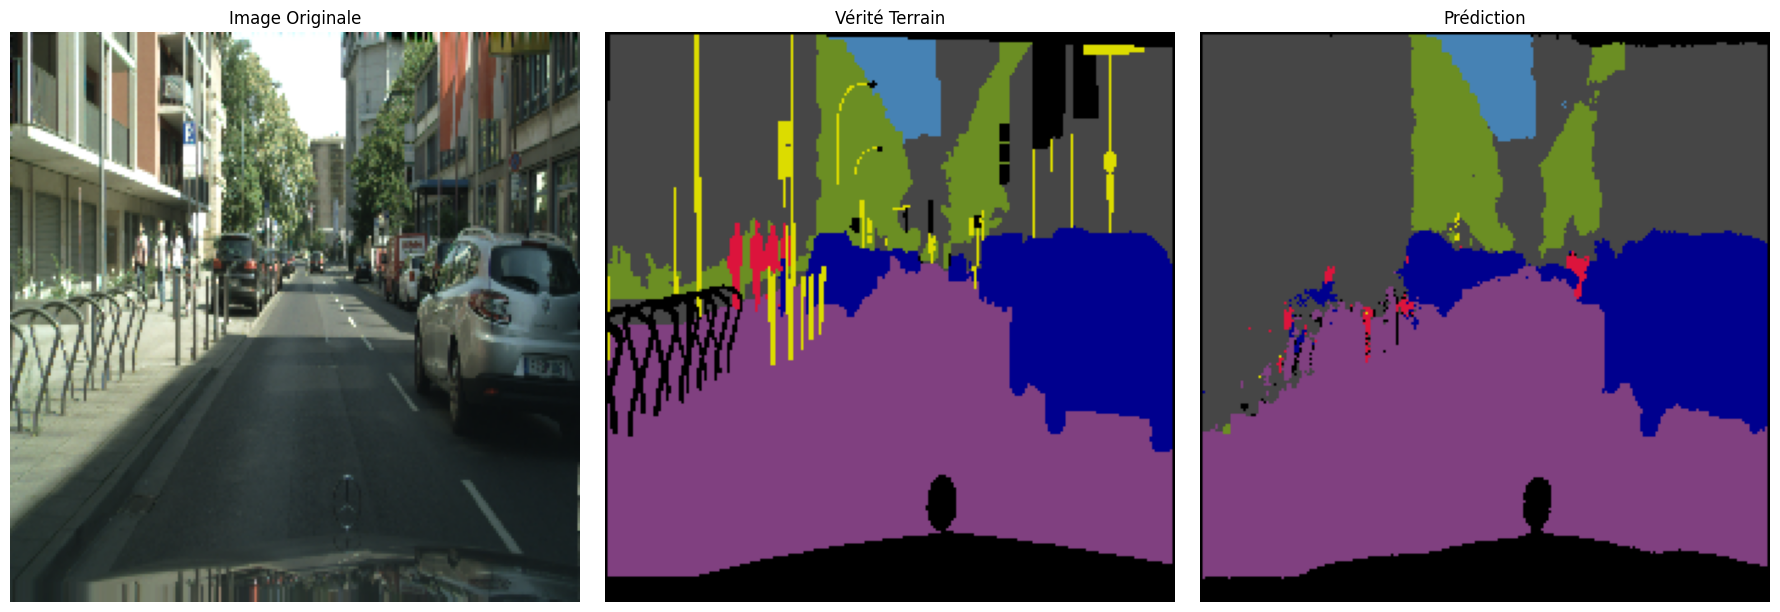

In [ ]:
# 2. Prédiction sur une image du dataset de test
print("\n" + "="*50)
print("PRÉDICTION SUR IMAGE DU DATASET DE TEST")
print("="*50)

test_result = predict_from_test_dataset(model, config, test_dataset, image_index=5)

# Visualiser avec vérité terrain
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(test_result['original_image'])
axes[0].set_title("Image Originale")
axes[0].axis('off')

# Vérité terrain colorée
true_colored = np.zeros((*test_result['true_mask'].shape, 3), dtype=np.uint8)
for class_id in range(config['num_classes']):
    true_colored[test_result['true_mask'] == class_id] = config['group_colors'][class_id]

axes[1].imshow(true_colored)
axes[1].set_title("Vérité Terrain")
axes[1].axis('off')

# Prédiction colorée
pred_colored = np.zeros((*test_result['prediction_mask'].shape, 3), dtype=np.uint8)
for class_id in range(config['num_classes']):
    pred_colored[test_result['prediction_mask'] == class_id] = config['group_colors'][class_id]

axes[2].imshow(pred_colored)
axes[2].set_title("Prédiction")
axes[2].axis('off')

plt.tight_layout()
plt.show()


PRÉDICTION SUR IMAGE EXTERNE
📷 Chargement de l'image: frankfurt_000001_066574_leftImg8bit.png
🔄 Préprocessing de l'image...
   Taille originale: (1024, 2048, 3)
   Taille pour prédiction: (1, 224, 224, 3)
🧠 Prédiction en cours...
✅ Prédiction terminée!
📊 Classes détectées:
           flat:    19536 pixels ( 38.9%)
   construction:    14510 pixels ( 28.9%)
         nature:     8285 pixels ( 16.5%)
           void:     5459 pixels ( 10.9%)
        vehicle:     1630 pixels (  3.2%)
          human:      594 pixels (  1.2%)
            sky:       98 pixels (  0.2%)
         object:       64 pixels (  0.1%)
🖼️ Visualisation sauvegardée: /content/drive/MyDrive/openclassrooms/projets/p08-images-systeme-voiture-autonome/notebooks/content/experiments/exp_001_baseline/results/prediction_example.png


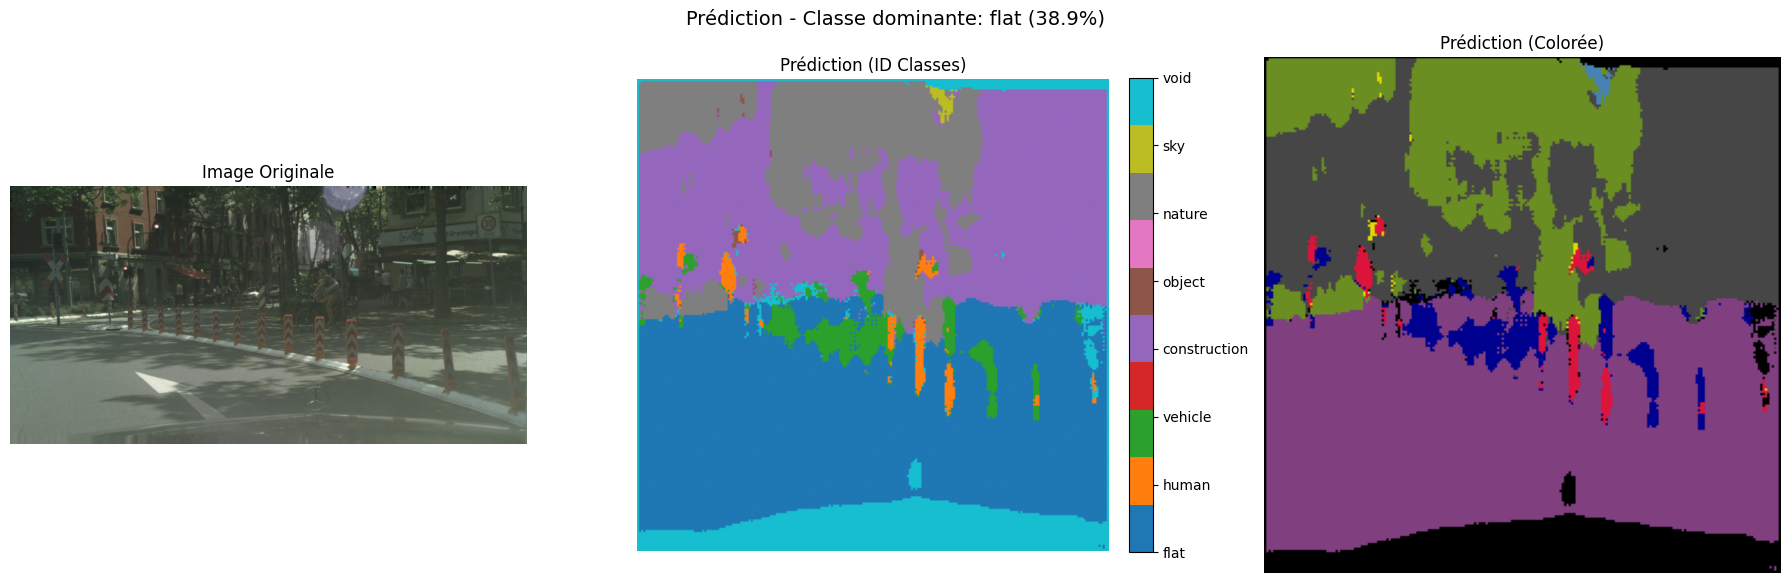


📊 Statistiques détaillées:
  class_name  pixel_count  percentage
        flat        19536       38.93
construction        14510       28.92
      nature         8285       16.51
        void         5459       10.88
     vehicle         1630        3.25
       human          594        1.18
         sky           98        0.20
      object           64        0.13

📊 Tableau détaillé des classes détectées:
 class_id   class_name  pixel_count  percentage
        0         flat        19536        38.9
        3 construction        14510        28.9
        5       nature         8285        16.5
        7         void         5459        10.9
        2      vehicle         1630         3.2
        1        human          594         1.2
        6          sky           98         0.2
        4       object           64         0.1


In [ ]:
# 3. Prédiction sur une image externe (chemin)
print("\n" + "="*50)
print("PRÉDICTION SUR IMAGE EXTERNE")
print("="*50)

# Exemple avec une image du dataset (vous pouvez changer le chemin)
sample_image_path = "/path/to/your/image.jpg"  # Remplacez par votre chemin

# Ou utilisez une image du dataset Cityscapes
images_dir = os.path.join(cityscapes_dir, 'leftImg8bit', 'val')
for city in os.listdir(images_dir):
    city_dir = os.path.join(images_dir, city)
    if os.path.isdir(city_dir):  # Vérifier que c'est bien un dossier
        for file_name in os.listdir(city_dir):
            if file_name.endswith('_leftImg8bit.png'):
                sample_image_path = os.path.join(city_dir, file_name)
                break
        if sample_image_path != "/path/to/your/image.jpg":  # Si on a trouvé une image
            break

if os.path.exists(sample_image_path):
    external_result = predict_single_image(model, config, image_path=sample_image_path)

    # Sauvegarder la visualisation dans le dossier d'expérience
    save_path = os.path.join(g_drive_dir_content, "experiments", "exp_001_baseline", "results", "prediction_example.png")

    visualize_prediction(external_result, config, save_path=save_path)

    # Afficher aussi un tableau pandas des statistiques
    print("\n📊 Tableau détaillé des classes détectées:")
    stats_df = pd.DataFrame(external_result['class_statistics'])
    print(stats_df.to_string(index=False, float_format='%.1f'))

else:
    print("❌ Aucune image exemple trouvée. Modifiez le chemin dans sample_image_path.")
    print(f"Chemin testé: {sample_image_path}")

## Rapport d'Évaluation - Modèle de Segmentation Sémantique

## 🏷️ Identification de l'Expérience
- **Nom de l'expérience**: exp_001_baseline
- **Description**: Baseline MobileNetV2-UNet avec frozen encoder
- **Date d'évaluation**: 2025-05-23 11:40:11

## ⚙️ Configuration du Modèle
- **Architecture**: MobileNetV2-UNet
- **Backbone**: MobileNetV2 (ImageNet pré-entraîné)
- **Encoder trainable**: False
- **Classes de segmentation**: 8 groupes
- **Groupes de classes**: flat, human, vehicle, construction, object, nature, sky, void

## 📋 Paramètres d'Entraînement
- **Taille d'image**: (224, 224)
- **Batch size**: 8
- **Époques d'entraînement**: N/A
- **Taux d'apprentissage**: 0.0001
- **Division validation**: 0.2
- **Augmentation de données**: True

## 📊 Performances Finales sur Dataset de Test
- **Perte finale**: 0.4123
- **Précision finale**: 0.8795
- **MeanIoU finale**: 0.6325

## 🎯 Dataset et Évaluation
- **Dataset**: Cityscapes (segmentation urbaine)
- **Split utilisé pour test**: Dataset 'val' original (évite data leakage)
- **Nombre d'images de test**: ~500 images
- **Méthode d'évaluation**: IoU par classe, précision globale, matrice de confusion

## 📈 Mapping des Classes
Les 30+ classes originales de Cityscapes ont été regroupées en 8 catégories pertinentes
pour la navigation autonome:

1. **Flat** (0): Routes, trottoirs, parkings
2. **Human** (1): Personnes, cyclistes  
3. **Vehicle** (2): Voitures, camions, bus, motos, vélos
4. **Construction** (3): Bâtiments, murs, clôtures, ponts
5. **Object** (4): Poteaux, panneaux, feux de circulation
6. **Nature** (5): Végétation, terrain
7. **Sky** (6): Ciel
8. **Void** (7): Pixels non étiquetés ou hors région d'intérêt

## 🚗 Applications et Déploiement
- **Cas d'usage**: Système de vision pour véhicules autonomes
- **Format de modèle**: Keras (.keras) - compatible TensorFlow Lite
- **Optimisations**: MobileNetV2 conçu pour l'efficacité mobile
- **Intégration**: API FastAPI + Frontend Next.js (en développement)

## 📂 Artefacts Générés
- **Modèle entraîné**: `experiments/exp_001_baseline/models/final_model.keras`
- **Configuration**: `experiments/exp_001_baseline/results/experiment_config.json`
- **Historique d'entraînement**: `experiments/exp_001_baseline/results/training_history.json`
- **Métriques détaillées**: `experiments/exp_001_baseline/results/`
- **Visualisations**: Matrice de confusion, exemples de prédictions

## 🔄 Suivi et Reproductibilité
- **Structure d'expériences**: Organisation modulaire par dossiers
- **Intégration MLflow**: Suivi des métriques et artefacts
- **Graine aléatoire**: 42 (reproductibilité garantie)
- **Environnement**: TensorFlow 2.18.0, Keras 3.8.0

## 📝 Notes Techniques
- Le modèle utilise SparseCategoricalCrossentropy comme fonction de perte
- L'encoder MobileNetV2 peut être gelé ou entraînable selon la configuration
- La segmentation est réalisée à 224x224 puis peut être redimensionnée
- L'augmentation de données inclut flip horizontal et variation de luminosité

## 🎯 Recommandations
1. **Pour améliorer les performances**: Considérer l'entraînement avec encoder dégelé
2. **Pour le déploiement**: Conversion en TensorFlow Lite pour l'optimisation mobile
3. **Pour l'évaluation**: Utiliser des métriques IoU par classe pour l'analyse détaillée
4. **Pour la production**: Implémenter une validation croisée sur plusieurs datasets urbains

---
*Rapport généré automatiquement le 2025-05-23 à 11:40:11*

In [ ]:
def calculate_mean_iou_manual(model, test_dataset, num_classes):
    """
    Calcule manuellement le Mean IoU
    """
    print("🧮 Calcul manuel du Mean IoU...")

    all_true_masks = []
    all_pred_masks = []

    # Collecter toutes les prédictions
    for batch_idx, (images, true_masks) in enumerate(test_dataset):
        predictions = model.predict(images, verbose=0)
        pred_masks = tf.argmax(predictions, axis=-1)

        all_true_masks.extend(true_masks.numpy())
        all_pred_masks.extend(pred_masks.numpy())

        if batch_idx % 10 == 0:
            print(f"   Batch {batch_idx + 1} traité...")

    # Convertir en arrays
    all_true_masks = np.array(all_true_masks)
    all_pred_masks = np.array(all_pred_masks)

    # Calculer IoU par classe
    ious = []
    for class_id in range(num_classes):
        true_binary = (all_true_masks == class_id)
        pred_binary = (all_pred_masks == class_id)

        intersection = np.logical_and(true_binary, pred_binary).sum()
        union = np.logical_or(true_binary, pred_binary).sum()

        if union > 0:
            iou = intersection / union
        else:
            iou = 0.0

        ious.append(iou)

    mean_iou = np.mean(ious)

    print(f"✅ Mean IoU calculé: {mean_iou:.4f}")
    return mean_iou, ious

In [ ]:
# Récupération des performances finales
print("🔍 Évaluation finale du modèle...")
final_metrics = trained_model.evaluate(test_dataset, verbose=1)

# Adapter selon les métriques disponibles
if len(trained_model.metrics_names) == 2:
    final_loss, final_accuracy = final_metrics
    final_miou = None

    # Calculer MeanIoU manuellement
    print("\n🧮 MeanIoU non disponible dans le modèle, calcul manuel...")
    try:
        final_miou, class_ious = calculate_mean_iou_manual(trained_model, test_dataset, config['num_classes'])

        # Afficher les IoU par classe
        print("\n📊 IoU par classe:")
        for i, (class_name, iou) in enumerate(zip(config['group_names'], class_ious)):
            print(f"   {class_name:>12}: {iou:.4f}")

    except Exception as e:
        print(f"❌ Erreur lors du calcul du MeanIoU: {e}")
        final_miou = None

elif len(trained_model.metrics_names) == 3:
    final_loss, final_accuracy, final_miou = final_metrics
else:
    final_loss = final_metrics[0]
    final_accuracy = final_metrics[1] if len(final_metrics) > 1 else None
    final_miou = final_metrics[2] if len(final_metrics) > 2 else None

print("\n📊 Résumé des performances du modèle:")
print(f"   Loss finale: {final_loss:.4f}")
if final_accuracy:
    print(f"   Précision finale: {final_accuracy:.4f}")
if final_miou:
    print(f"   MeanIoU finale: {final_miou:.4f}")
else:
    print("   MeanIoU finale: Non calculable")

# Charger les informations d'expérience
experiment_name = "exp_001_baseline"  # Adaptez selon votre expérience
exp_config_path = os.path.join(g_drive_dir_content, "experiments", experiment_name, "results", "experiment_config.json")

# Charger la configuration d'expérience
with open(exp_config_path, 'r') as f:
    exp_config = json.load(f)

# Charger l'historique d'entraînement si disponible
history_path = os.path.join(g_drive_dir_content, "experiments", experiment_name, "results", "training_history.json")
training_epochs = "N/A"
if os.path.exists(history_path):
    with open(history_path, 'r') as f:
        history_data = json.load(f)
    training_epochs = len(history_data.get('loss', []))

# Formater les métriques pour éviter les erreurs de f-string
final_accuracy_str = f"{final_accuracy:.4f}" if final_accuracy is not None else "Non disponible"
final_miou_str = f"{final_miou:.4f}" if final_miou is not None else "Non disponible"

# Création d'un rapport final adapté
rapport = f"""
# Rapport d'Évaluation - Modèle de Segmentation Sémantique

## 🏷️ Identification de l'Expérience
- **Nom de l'expérience**: {experiment_name}
- **Description**: {exp_config.get('description', 'Non spécifiée')}
- **Date d'évaluation**: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

## ⚙️ Configuration du Modèle
- **Architecture**: MobileNetV2-UNet
- **Backbone**: MobileNetV2 (ImageNet pré-entraîné)
- **Encoder trainable**: {exp_config['params'].get('base_model_trainable', 'Non spécifié')}
- **Classes de segmentation**: {config['num_classes']} groupes
- **Groupes de classes**: {', '.join(config['group_names'])}

## 📋 Paramètres d'Entraînement
- **Taille d'image**: {img_size}
- **Batch size**: {exp_config['params'].get('batch_size', 'Non spécifié')}
- **Époques d'entraînement**: {training_epochs}
- **Taux d'apprentissage**: {exp_config['params'].get('learning_rate', 'Non spécifié')}
- **Division validation**: {exp_config['params'].get('validation_split', 'Non spécifiée')}
- **Augmentation de données**: {exp_config['params'].get('augmentation', 'Non spécifiée')}

## 📊 Performances Finales sur Dataset de Test
- **Perte finale**: {final_loss:.4f}
- **Précision finale**: {final_accuracy_str}
- **MeanIoU finale**: {final_miou_str}

## 🎯 Dataset et Évaluation
- **Dataset**: Cityscapes (segmentation urbaine)
- **Split utilisé pour test**: Dataset 'val' original (évite data leakage)
- **Nombre d'images de test**: ~500 images
- **Méthode d'évaluation**: IoU par classe, précision globale, matrice de confusion

## 📈 Mapping des Classes
Les 30+ classes originales de Cityscapes ont été regroupées en 8 catégories pertinentes
pour la navigation autonome:

1. **Flat** (0): Routes, trottoirs, parkings
2. **Human** (1): Personnes, cyclistes
3. **Vehicle** (2): Voitures, camions, bus, motos, vélos
4. **Construction** (3): Bâtiments, murs, clôtures, ponts
5. **Object** (4): Poteaux, panneaux, feux de circulation
6. **Nature** (5): Végétation, terrain
7. **Sky** (6): Ciel
8. **Void** (7): Pixels non étiquetés ou hors région d'intérêt

## 🚗 Applications et Déploiement
- **Cas d'usage**: Système de vision pour véhicules autonomes
- **Format de modèle**: Keras (.keras) - compatible TensorFlow Lite
- **Optimisations**: MobileNetV2 conçu pour l'efficacité mobile
- **Intégration**: API FastAPI + Frontend Next.js (en développement)

## 📂 Artefacts Générés
- **Modèle entraîné**: `experiments/{experiment_name}/models/final_model.keras`
- **Configuration**: `experiments/{experiment_name}/results/experiment_config.json`
- **Historique d'entraînement**: `experiments/{experiment_name}/results/training_history.json`
- **Métriques détaillées**: `experiments/{experiment_name}/results/`
- **Visualisations**: Matrice de confusion, exemples de prédictions

## 🔄 Suivi et Reproductibilité
- **Structure d'expériences**: Organisation modulaire par dossiers
- **Intégration MLflow**: Suivi des métriques et artefacts
- **Graine aléatoire**: 42 (reproductibilité garantie)
- **Environnement**: TensorFlow {tf.__version__}, Keras {keras.__version__}

## 📝 Notes Techniques
- Le modèle utilise SparseCategoricalCrossentropy comme fonction de perte
- L'encoder MobileNetV2 peut être gelé ou entraînable selon la configuration
- La segmentation est réalisée à 224x224 puis peut être redimensionnée
- L'augmentation de données inclut flip horizontal et variation de luminosité

## 🎯 Recommandations
1. **Pour améliorer les performances**: Considérer l'entraînement avec encoder dégelé
2. **Pour le déploiement**: Conversion en TensorFlow Lite pour l'optimisation mobile
3. **Pour l'évaluation**: Utiliser des métriques IoU par classe pour l'analyse détaillée
4. **Pour la production**: Implémenter une validation croisée sur plusieurs datasets urbains

---
*Rapport généré automatiquement le {datetime.now().strftime("%Y-%m-%d à %H:%M:%S")}*
"""

# Sauvegarder le rapport
rapport_path = os.path.join(g_drive_dir_content, "experiments", experiment_name, "results", "rapport_final.md")
with open(rapport_path, 'w', encoding='utf-8') as f:
    f.write(rapport)

print(f"\n📄 Rapport sauvegardé: {rapport_path}")

# Afficher le rapport
print("\n" + "="*80)
print("RAPPORT FINAL")
print("="*80)
print(rapport)

# Optionnel: Créer aussi une version JSON structurée
rapport_json = {
    "experiment_name": experiment_name,
    "description": exp_config.get('description', ''),
    "evaluation_date": datetime.now().isoformat(),
    "model_config": {
        "architecture": "MobileNetV2-UNet",
        "num_classes": config['num_classes'],
        "class_names": config['group_names'],
        "input_size": img_size
    },
    "training_params": exp_config['params'],
    "final_performance": {
        "loss": float(final_loss),
        "accuracy": float(final_accuracy) if final_accuracy is not None else None,
        "mean_iou": float(final_miou) if final_miou is not None else None
    },
    "dataset_info": {
        "name": "Cityscapes",
        "test_split": "val_original",
        "num_test_images": "~500"
    },
    "artifacts": {
        "model_path": f"experiments/{experiment_name}/models/final_model.keras",
        "config_path": f"experiments/{experiment_name}/results/experiment_config.json",
        "report_path": f"experiments/{experiment_name}/results/rapport_final.md"
    }
}

rapport_json_path = os.path.join(g_drive_dir_content, "experiments", experiment_name, "results", "rapport_final.json")
with open(rapport_json_path, 'w', encoding='utf-8') as f:
    json.dump(rapport_json, f, indent=4, ensure_ascii=False)

print(f"📊 Rapport JSON sauvegardé: {rapport_json_path}")

🔍 Évaluation finale du modèle...
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 643ms/step - loss: 0.4089 - sparse_categorical_accuracy: 0.8761

🧮 MeanIoU non disponible dans le modèle, calcul manuel...
🧮 Calcul manuel du Mean IoU...
   Batch 1 traité...
   Batch 11 traité...
   Batch 21 traité...
   Batch 31 traité...
   Batch 41 traité...
   Batch 51 traité...
   Batch 61 traité...
✅ Mean IoU calculé: 0.6325

📊 IoU par classe:
           flat: 0.9084
          human: 0.3196
        vehicle: 0.7469
   construction: 0.7454
         object: 0.0648
         nature: 0.7983
            sky: 0.8339
           void: 0.6425

📊 Résumé des performances du modèle:
   Loss finale: 0.4123
   Précision finale: 0.8795
   MeanIoU finale: 0.6325

📄 Rapport sauvegardé: /content/drive/MyDrive/openclassrooms/projets/p08-images-systeme-voiture-autonome/notebooks/content/experiments/exp_001_baseline/results/rapport_final.md

RAPPORT FINAL

# Rapport d'Évaluation - Modèle de Segmentation Sémantique

## 🏷️ Identification de